# EZ: Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob as glob
import pdf_ccdf
import h5py
import sys,tqdm
sys.path.append('/home/santiago_b/ez_model/src/')
import model as ez
import scipy.stats as stats

In [2]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["font.serif"] = "Times New Roman"

In [3]:
# Threshold
def onoff_dist(T,dt,thresh):
    wt = []
    t_off = dt
    for q in T:
        if (q<=thresh):
            t_off += dt
        else:
            wt.append(t_off)
            t_off = dt

    return np.array(wt)

In [4]:
# Choose output directory
odir = './Figures/'

In [7]:
idirs = ['../1000x200']

## List of $q_{in}$ values

In [8]:
q_ins_Ny = []
for idir in idirs:
    dirs = sorted(glob.glob(idir+'/q*'))
    
    Ny = float(idir.split('x')[1][:])
    
    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))
        q_ins_Ny.append(q_in_real/Ny)

q_ins_Ny = np.unique(np.array(q_ins_Ny))
print(q_ins_Ny)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


In [9]:
for run in runs[:1]:
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    f = h5py.File(fname,'r')
    print(run)
    for subdat in f:
        print(subdat)
        print(f[subdat].keys())
#         print(subdat['tasks'].keys())
#         print(subdat['scales']['sim_time'][:])
    f.close()

q_1d000000e+01
parameters
<KeysViewHDF5 ['Nx', 'Ny', 'c_0', 'f', 'q_in', 'rho', 'skipmax', 'u_p']>
scalars
<KeysViewHDF5 ['bed_activity', 'e_last', 'e_mid', 'q_mid', 'q_out', 'time', 'tstep']>


In [10]:
# Scale for coloring:
def cscale_qins(q_in,q_ins_Ny):
    maxt = (np.max(q_ins_Ny))
    mint = (np.min(q_ins_Ny))
    return ((q_in) - mint)/(maxt-mint)

# Time series

$$ q^*_{in} = \frac{q_{in}}{\tilde{\Delta t}_{s}} \frac{4}{3} \pi \frac{1}{\tilde{b}} \left(\frac{\rho_w}{\rho_s - \rho_w}\right)^{1/2}$$

## Bed slopes

In [11]:
plot_yn = False

In [13]:
# params = {'Nx':self.Nx,'Ny':self.Ny,'c_0':self.c_0,'f':self.f,'skipmax':self.skipmax,'u_p':self.u_p,'rho':self.rho,'q_in':self.q_in}
# odata = ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
# Nx,Ny,c_0,f,skipmax,u_p,q_in,rho = 1.25,initial=0.0

In [13]:
slopes_bed = dict([])
prob_d = dict([])
slopes_bed_t = dict([])
qin_reals_bed = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    slopes_l_t = []
    q8s_l = []
    prob_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
#         if ((q_in<0.1)&(idir=='../400x80/') or (q_in<0.1)&(idir=='../400x40/')):
#         if ((q_in<0.02)&(idir=='../400x80/')):
#             print("Skipping %s" % run)
#             pass
#         else:
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
    for ii,run in enumerate(runs):
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        u_p = file['parameters']['u_p'][()]
        skipmax = file['parameters']['skipmax'][()]
        file.close()

        # Initialize
        set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)

        # Load data:
        set_q.load_data(str(glob.glob(idir+'/'+run+'/*_state.h5')[0]))

        # Plot
#         print("q_in = %s" % q_in)

        if q_in<1:
            q_in_real = 1/int(1/q_in)
#             print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
#             print("q_in > 1",int(q_in))
        q8s_l.append(q_in_real)
    #     set_q.plot_min()

        z_avg = np.mean(set_q.z[:,5:-5],axis=0)
        x = np.arange(len(z_avg))
        m,b = np.polyfit(x,z_avg,1)
        slopes_l.append(m)
        slopes_l_t.append(set_q.scrit)
        
        # Average c_0
        # Run for 1000 time steps
        ne = 0
        ptemp = np.zeros(set_q.e.shape)
        N = 50
        for i in tqdm.tqdm(range(N)):
            set_q.step()
            ne += np.sum(set_q.e)/N
            ptemp += set_q.p_calc()/N
        prob_l.append(np.mean(ptemp)*Nx*Ny/ne)
#         s=np.diff(set_q.z,axis=1)
#         cs = c_0*np.sqrt(1+s**2)
#         cs[s>0]=0
#         prob_l.append(np.mean(cs))
        
    slopes_bed['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    slopes_bed_t['%sx%s' % (Nx,Ny)] = np.array(slopes_l_t)
    qin_reals_bed['%sx%s' % (Nx,Ny)] = np.array(q8s_l)
    prob_d['%sx%s' % (Nx,Ny)] = np.array(prob_l)


  0%|          | 0/50 [00:00<?, ?it/s]

Working on ../1000x200


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


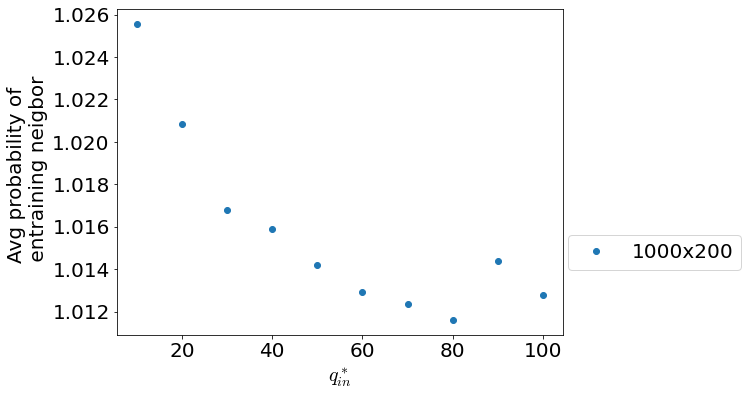

In [14]:
plt.figure(figsize=(8,6))
for dirr in slopes_bed:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.plot(qin_reals_bed[dirr],prob_d[dirr],marker = 'o',ls='',label = dirr)
plt.legend(loc=(1.01,0.2))
plt.xlabel("$q^*_{in}$")
# plt.xlabel("$c_0$")
plt.ylabel("Avg probability of \n entraining neigbor")
# plt.ylabel("Avg $c$")
plt.show()

-2.2414380975181043


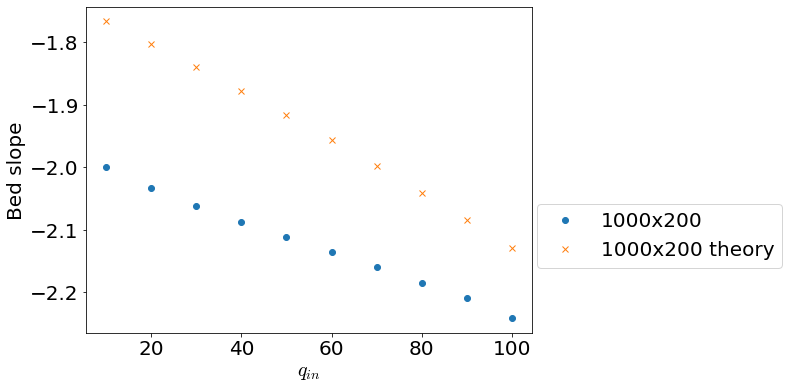

In [16]:
plt.figure(figsize=(8,6))
# slope_c = np.sqrt((1/((2.785*set_q.c_0)**2))-1)
slope_c = -set_q.scrit
# plt.axhline(y=-slope_c,c='r',ls='--')
for dirr in slopes_bed:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
    plt.plot(qin_reals_bed[dirr],slopes_bed[dirr],marker = 'o',ls='',label = dirr)
    plt.plot(qin_reals_bed[dirr],slopes_bed_t[dirr],marker = 'x',ls='',label = dirr+" theory")
    print(m)
plt.legend(loc=(1.01,0.2))
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}$")
plt.ylabel("Bed slope")
# plt.title("Measuring Bed Activity")
plt.show()

-0.002583832280109114


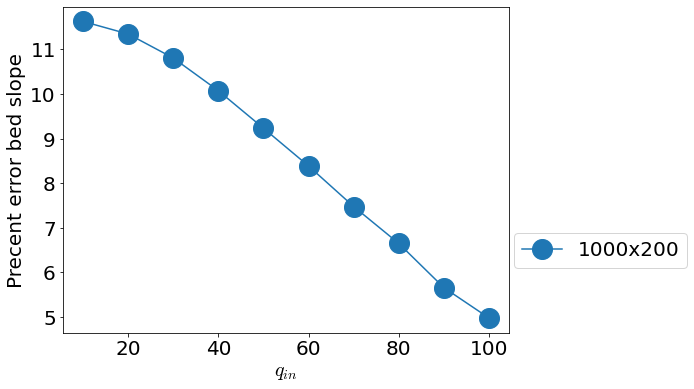

In [19]:
plt.figure(figsize=(8,6))
# slope_c = np.sqrt((1/((2.785*set_q.c_0)**2))-1)
slope_c = -set_q.scrit
# plt.axhline(y=-slope_c,c='r',ls='--')
for dirr in slopes_bed:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.plot(qin_reals_bed[dirr],slopes_bed[dirr],marker = 'o',c=cm.copper(np.sqrt(Ny/(512))),ls='',label = dirr)
#     plt.plot(qin_reals_bed[dirr],slopes_bed_t[dirr]-slopes_bed_t[dirr][0]+slopes_bed[dirr][0],marker = 'x',c=cm.copper(np.sqrt(Ny/(512))),ls='',label = dirr+" theory")
    plt.plot(qin_reals_bed[dirr],100*abs(slopes_bed[dirr]-slopes_bed_t[dirr])/abs(slopes_bed[dirr]),marker = 'o',ls='-',ms = (Nx/1000)*20, label = dirr)
    m,b = np.polyfit(qin_reals_bed[dirr],slopes_bed[dirr],1)
    print(m)
plt.legend(loc=(1.01,0.2))
# plt.xlabel("$q^*_{in}$")
plt.xlabel("$q_{in}$")
plt.ylabel("Precent error bed slope")
# plt.title("Measuring Bed Activity")
plt.show()

## Max values as a function of size

In [46]:
max_ba = dict([])
qin_reals_ba = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
    for ii,run in enumerate(runs):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
#         norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
#         q8_in = norm*q_in_real

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
#         q_out = file['scalars']['q_out'][()]
#         q8_out = q_out*norm
#         bed_activity = file['scalars']['bed_activity'][()]
        q_out = file['scalars']['e_last'][()][300:]

        # Close file:
        file.close()

#         ba_max = np.max(q_out)
        ba_max = np.mean(np.sort(q_out)[-10:])
        
    #     if (q_in_real<3):
#         nbin = 20

#         # Choose data to plot:
#         q = bed_activity

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,output='pdf')#,xmin = 2e-3,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3# Number of grains considered 'too small'
#         xcutoff = nbeads/(Nx*Ny) # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

# #         if idir=='../256x256/':
#         if plot_yn:
#             plt.figure(figsize=(8,6))
#             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
#             plt.loglog(x,pdf,marker='x',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        
#         # Fit
#         if ((idir=='../400x80/') or (idir=='../128x128/')):
#             fitmax = 7e-4  # For 200x40
#         elif (idir=='../256x256/'):
#             fitmax = 4e-4
#         elif (idir=='../200x40/'):
#             fitmax = 2e-3
#         else:
#             fitmax = 1e-3  # For 400x80
#         fitmin = xcutoff 
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         if plot_yn:
#             plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#             plt.legend()#loc=(1.01,0.0))
#             plt.xlabel(r"Bed Activity")
#             plt.xlabel(r"$q_{out}$")
        if q_in_real>=1:
            slopes_l.append(ba_max)
            q8s_l.append(q_in_real)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)

#         if plot_yn:
#             plt.show()
#             plt.close()
        
    max_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)


Working on ../1000x200


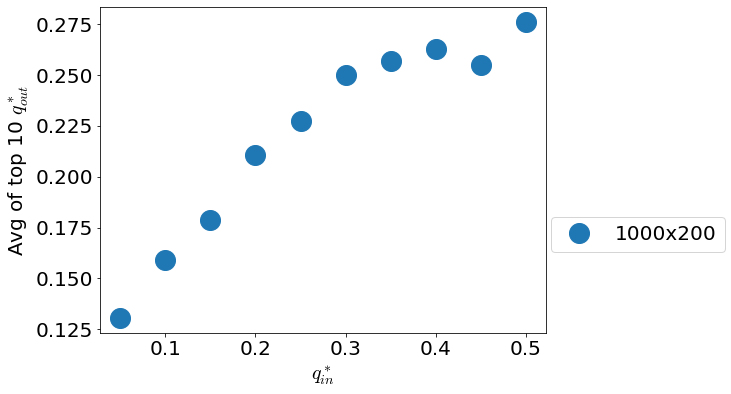

In [47]:
plt.figure(figsize=(8,6))
for dirr in max_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(qin_reals_ba[dirr]/Ny,(max_ba[dirr]/Ny),marker = 'o',ms=20*(Nx/1000)**0.7,ls='',label = dirr)
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$q^*_{in}$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Avg of top 10 $q^*_{out}$")
# plt.title("Measuring Bed Activity")
plt.show()

**What sets the maximum value?** An on-off intermittency argument.

Well, we know on average that $\langle q^* \rangle = q^*_{in}$. If we're closer to the threshold of motion (or if our noise variance is larger), then we spend _more_ time close to zero. This means that, if we want to have $\langle q^* \rangle = q^*_{in}$, that our bursts need to become larger and larger as we approach the critical value. 

Remember that $\langle \Delta t \rangle = \tilde{t} \sqrt{S}  \ (\tau-\tau_c)^{-1}$, where $\tilde{t}$ is a time-scale. The waiting time scales like one over the offset, but once it's in the nonlinear regime ($\equiv q^*_{burst}$), then we expect it to have a constant time, call it the same time-scale defined above: $\tilde{t}$, which is constant. Let's do a simple model for the average of $q^*$ (ignoring constants):

$$\langle q^* \rangle  \sim \frac{q^*_{burst} \tilde{t}}{\Delta t + \tilde{t}} = \frac{1}{\sqrt{S}  \ (\tau-\tau_c)^{-1} + 1} q^*_{burst} = q^*_{in} $$ 

This means that we expect $q^*_{burst} \sim q^*_{in} \ \sqrt{S}  \ (\tau-\tau_c)^{-1}$. If the variance of the noise is proportional to $\sigma^2 = S \propto (q^*_{in} \ N_y)^{-1}$ (due to discreteness). We also know that the shear-stress offset at equilibrium is: $\tau-\tau_c = q^*_{in}/(\tilde{A} / a - q^*_{in})$, then we get:

$$q^*_{burst} \sim q^*_{in} \ \sqrt{S}  \ (\tau-\tau_c)^{-1} \sim \frac{\tilde{A} / a - q^*_{in}}{\sqrt{q^*_{in} \ N_y}} \sim \frac{1}{\sqrt{q^*_{in} \ N_y}}$$

since $\tilde{A}/a \sim 5$ in our simulations.

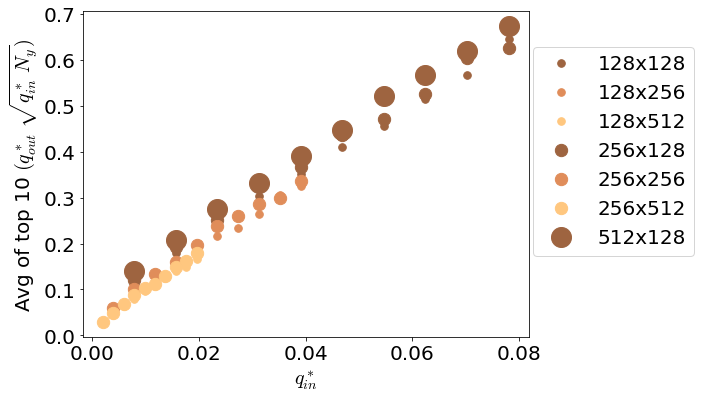

In [27]:
plt.figure(figsize=(8,6))
for dirr in max_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(qin_reals_ba[dirr]/Ny,(max_ba[dirr]/Ny)*(Ny*qin_reals_ba[dirr]/Ny)**(0.5),marker = 'o',c=cm.copper(np.sqrt(Ny/512)),ms=20*(Nx/512)**0.7,ls='',label = dirr)
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$q^*_{in}$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Avg of top 10 $(q^*_{out} \ \sqrt{q^*_{in} \ N_y})$")
# plt.title("Measuring Bed Activity")
plt.show()

Shouldn't really be a function of $q^*_{in}$ anymore, and I'm not sure about the discrepancy. This may be due to the fact that effective neighbor numbers change for larger $q^*_{in}$ (need to correct or measure this and see if applying it here helps), or something else I'm not thinking about... However, the collapse of $N_y$ dependence is nice to see!

It still seems to depend on $q^*_{in}$, why?

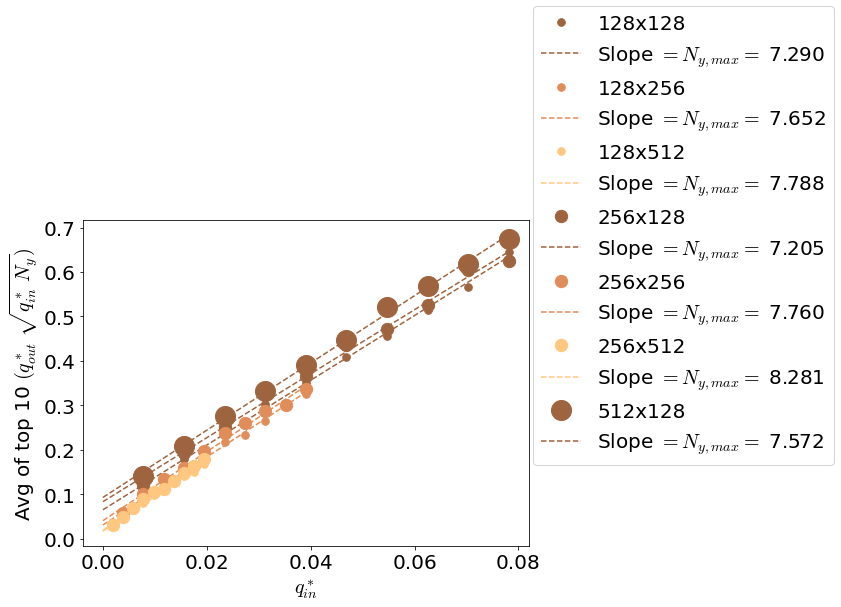

In [28]:
plt.figure(figsize=(8,6))
for dirr in max_ba:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(qin_reals_ba[dirr]/Ny,(max_ba[dirr]/Ny)*(Ny*qin_reals_ba[dirr]/Ny)**(0.5),marker = 'o',c=cm.copper(np.sqrt(Ny/512)),ms=20*(Nx/512)**0.7,ls='',label = dirr)

    xplt = np.linspace(0,np.max(qin_reals_ba[dirr]/Ny),1000)
    m,b = np.polyfit(qin_reals_ba[dirr]/Ny,(max_ba[dirr]/Ny)*(Ny*qin_reals_ba[dirr]/Ny)**(0.5),1)
    plt.plot(xplt,xplt*m+b,'--',c=cm.copper(np.sqrt(Ny/512)),label = r'Slope $= N_{y,max} =$ %.3f' % m)
plt.legend(loc=(1.01,0.25))
plt.xlabel("$q^*_{in}$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Avg of top 10 $(q^*_{out} \ \sqrt{q^*_{in} \ N_y})$")
# plt.title("Measuring Bed Activity")
plt.show()

## Skewness

In [48]:
skews_e = dict([])
skews_t = dict([])
qin_reals_ba = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    skews_e_l = []
    skews_t_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
    for ii,run in enumerate(runs):
        print("Working on %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        u_p = file['parameters']['u_p'][()]
        skipmax = file['parameters']['skipmax'][()]
        q = file['scalars']['e_last'][()][300:]

        # Close file:
        file.close()

        
        mean = np.mean(q)
        var = np.var(q)
        p = (var-mean)/(var)
        r = mean**2/(var-mean)
        skews_t_l.append((1+p)/np.sqrt(r*p))

        skews_e_l.append(stats.skew(q))
        q8s_l.append(q_in)
        
    skews_t['%sx%s' % (Nx,Ny)] = np.array(skews_t_l)
    skews_e['%sx%s' % (Nx,Ny)] = np.array(skews_e_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)


Working on ../1000x200
Working on q_1d000000e+01
Working on q_2d000000e+01
Working on q_3d000000e+01
Working on q_4d000000e+01
Working on q_5d000000e+01
Working on q_6d000000e+01
Working on q_7d000000e+01
Working on q_8d000000e+01
Working on q_9d000000e+01
Working on q_1d000000e+02


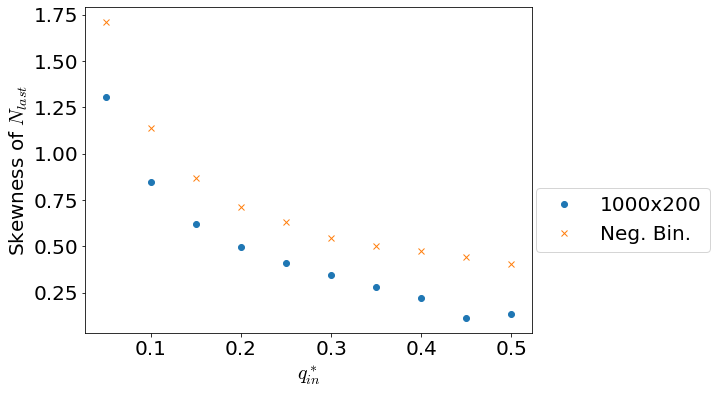

In [49]:
plt.figure(figsize=(8,6))
for dirr in skews_e:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(qin_reals_ba[dirr]/Ny,skews_e[dirr],marker = 'o',ls='',label = dirr)#,ms=20*(Nx/512)**0.7
    plt.plot(qin_reals_ba[dirr]/Ny,skews_t[dirr],marker = 'x',ls='',label = "Neg. Bin.")#,ms=20*(Nx/512)**0.7
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$q^*_{in}$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Skewness of $N_{last}$")
# plt.title("Measuring Bed Activity")
plt.show()

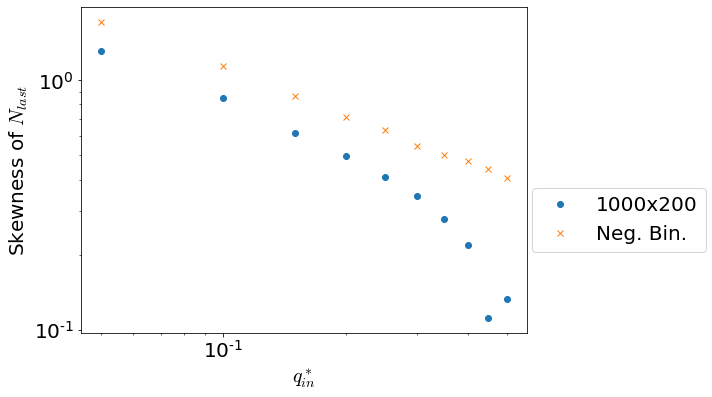

In [50]:
plt.figure(figsize=(8,6))
for dirr in skews_e:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.loglog(qin_reals_ba[dirr]/Ny,skews_e[dirr],marker = 'o',ls='',label = dirr)#,ms=20*(Nx/512)**0.7
    plt.loglog(qin_reals_ba[dirr]/Ny,skews_t[dirr],marker = 'x',ls='',label = "Neg. Bin.")#,ms=20*(Nx/512)**0.7
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$q^*_{in}$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Skewness of $N_{last}$")
# plt.title("Measuring Bed Activity")
plt.show()

In [51]:
skews_e = dict([])
skews_t = dict([])
qin_reals_ba = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    skews_e_l = []
    skews_t_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
    for ii,run in enumerate(runs):
        print("Working on %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        u_p = file['parameters']['u_p'][()]
        skipmax = file['parameters']['skipmax'][()]
        q = file['scalars']['q_out'][()][300:]/q_in

        # Close file:
        file.close()

        
        mean = np.mean(q)
        var = np.var(q)
        p = (var-mean)/(var)
        r = mean**2/(var-mean)
        skews_t_l.append((1+p)/np.sqrt(r*p))

        skews_e_l.append(stats.skew(q))
        q8s_l.append(q_in)
        
    skews_t['%sx%s' % (Nx,Ny)] = np.array(skews_t_l)
    skews_e['%sx%s' % (Nx,Ny)] = np.array(skews_e_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)


Working on ../1000x200
Working on q_1d000000e+01
Working on q_2d000000e+01
Working on q_3d000000e+01
Working on q_4d000000e+01
Working on q_5d000000e+01
Working on q_6d000000e+01
Working on q_7d000000e+01
Working on q_8d000000e+01
Working on q_9d000000e+01
Working on q_1d000000e+02


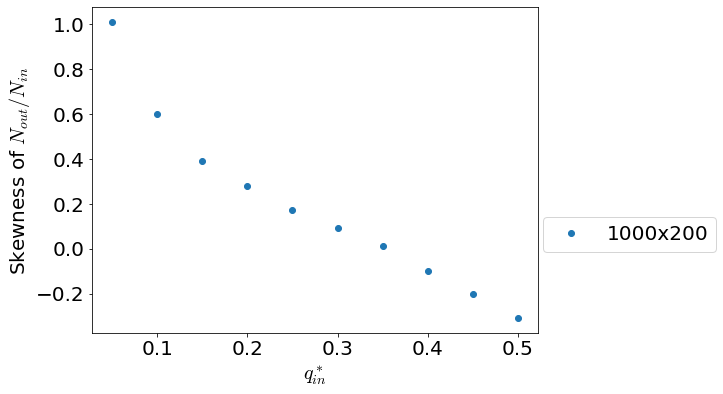

In [52]:
plt.figure(figsize=(8,6))
for dirr in skews_e:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(qin_reals_ba[dirr]/Ny,skews_e[dirr],marker = 'o',ls='',label = dirr)#,ms=20*(Nx/512)**0.7
#     plt.plot(qin_reals_ba[dirr]/Ny,skews_t[dirr],marker = 'x',c=cm.Reds(np.sqrt(Ny/2000)),ls='',label = "Neg. Bin.")#,ms=20*(Nx/512)**0.7
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$q^*_{in}$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Skewness of $N_{out}/N_{in}$")
# plt.title("Measuring Bed Activity")
plt.show()

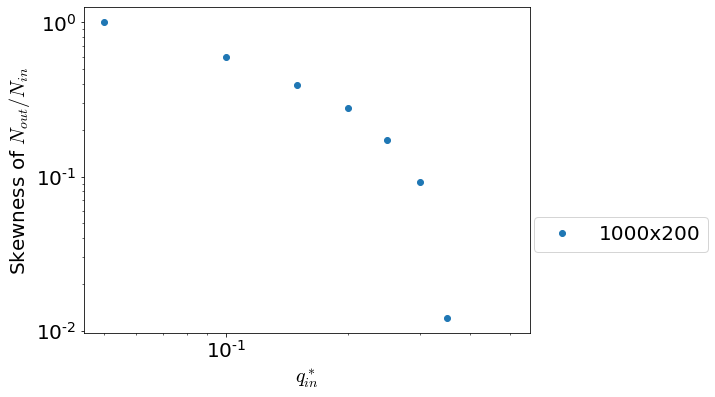

In [53]:
plt.figure(figsize=(8,6))
for dirr in skews_e:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.loglog(qin_reals_ba[dirr]/Ny,skews_e[dirr],marker = 'o',ls='',label = dirr)#,ms=20*(Nx/512)**0.7
#     plt.plot(qin_reals_ba[dirr]/Ny,skews_t[dirr],marker = 'x',c=cm.Reds(np.sqrt(Ny/2000)),ls='',label = "Neg. Bin.")#,ms=20*(Nx/512)**0.7
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$q^*_{in}$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Skewness of $N_{out}/N_{in}$")
# plt.title("Measuring Bed Activity")
plt.show()

In [54]:
skews_e = dict([])
skews_t = dict([])
qin_reals_ba = dict([])
for idir in idirs:
    print("Working on %s" % idir)
    skews_e_l = []
    skews_t_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
    for ii,run in enumerate(runs):
        print("Working on %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        u_p = file['parameters']['u_p'][()]
        skipmax = file['parameters']['skipmax'][()]
        q = file['scalars']['bed_activity'][()][300:]/q_in

        # Close file:
        file.close()

        
        mean = np.mean(q)
        var = np.var(q)
        p = (var-mean)/(var)
        r = mean**2/(var-mean)
        skews_t_l.append((1+p)/np.sqrt(r*p))

        skews_e_l.append(stats.skew(q))
        q8s_l.append(q_in)
        
    skews_t['%sx%s' % (Nx,Ny)] = np.array(skews_t_l)
    skews_e['%sx%s' % (Nx,Ny)] = np.array(skews_e_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)


Working on ../1000x200
Working on q_1d000000e+01
Working on q_2d000000e+01
Working on q_3d000000e+01
Working on q_4d000000e+01
Working on q_5d000000e+01
Working on q_6d000000e+01
Working on q_7d000000e+01
Working on q_8d000000e+01
Working on q_9d000000e+01
Working on q_1d000000e+02


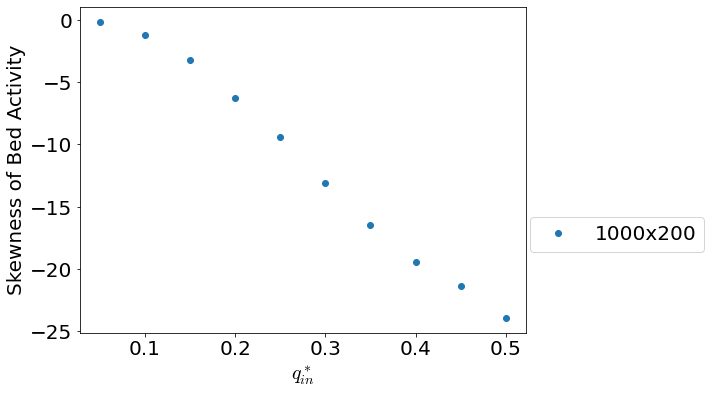

In [55]:
plt.figure(figsize=(8,6))
for dirr in skews_e:
    Nx = float(dirr.split('x')[0])
    Ny = float(dirr.split('x')[1])
#     plt.axhline(y=1,c='r',ls='--')
    plt.plot(qin_reals_ba[dirr]/Ny,skews_e[dirr],marker = 'o',ls='',label = dirr)#,ms=20*(Nx/512)**0.7
#     plt.plot(qin_reals_ba[dirr]/Ny,skews_t[dirr],marker = 'x',c=cm.Reds(np.sqrt(Ny/2000)),ls='',label = "Neg. Bin.")#,ms=20*(Nx/512)**0.7
# xplt = np.linspace(0,np.max(q_ins_Ny),1000)
# plt.plot(xplt,xplt,'-r',label='1:1')
plt.legend(loc=(1.01,0.25))
plt.xlabel("$q^*_{in}$")
# plt.xlabel("$q_{in}/N_y$")
# plt.ylabel(r"Max$(q_{out}/N_y)$")
plt.ylabel(r"Skewness of Bed Activity")
# plt.title("Measuring Bed Activity")
plt.show()

# Profiles

Working on q_1d000000e+01
Working on q_2d000000e+01
Working on q_3d000000e+01
Working on q_4d000000e+01
Working on q_5d000000e+01
Working on q_6d000000e+01
Working on q_7d000000e+01
Working on q_8d000000e+01
Working on q_9d000000e+01
Working on q_1d000000e+02


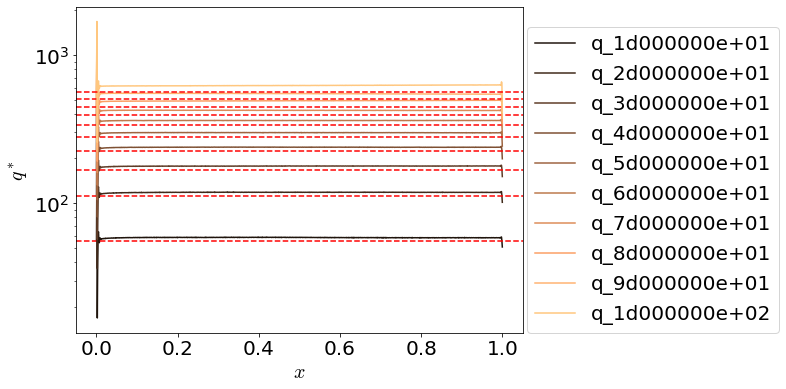

In [37]:
plt.figure(figsize=(8,6))
for run in runs:
    print("Working on %s" % run)
    # Open 
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    u_p = file['parameters']['u_p'][()]
    skipmax = file['parameters']['skipmax'][()]
    # Initialize
    set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)
#     norm = set_q.dt**-1 * (4/3.) * np.pi * 1/float(Ny) * set_q.rho
    q8_in = q_in/set_q.norm

    # Close file:
    file.close()
    
    qmean = np.loadtxt(idir+'/'+run+'/mean_q.txt')
    qvar = np.loadtxt(idir+'/'+run+'/var_q.txt')
    x = np.loadtxt(idir+'/'+run+'/x.txt')
    plt.semilogy(x,qmean,label=run,c=cm.copper(q_in/100))
    plt.axhline(y=q8_in,c='r',ls='--')
    
plt.xlabel(r"$x$")
plt.ylabel(r"$q^*$")
plt.legend(loc=(1.01,0.0))
plt.show()

Working on q_1d000000e+01
0.09484735785425576
Working on q_2d000000e+01
0.03246617019963615
Working on q_3d000000e+01
0.014633687552994502
Working on q_4d000000e+01
0.0071198573324955374
Working on q_5d000000e+01
0.004237060316427764
Working on q_6d000000e+01


<ipython-input-40-4d64f7405ab4>:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(xplt,b+m*np.log(xplt),'--r')
<ipython-input-40-4d64f7405ab4>:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(xplt,b+m*np.log(xplt),'--r')
<ipython-input-40-4d64f7405ab4>:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(xplt,b+m*np.log(xplt),'--r')
<ipython-input-40-4d64f7405ab4>:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(xplt,b+m*np.log(xplt),'--r')
<ipython-input-40-4d64f7405ab4>:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(xplt,b+m*np.log(xplt),'--r')
<ipython-input-40-4d64f7405ab4>:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(xplt,b+m*np.log(xplt),'--r')
<ipython-input-40-4d64f7405ab4>:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(xplt,b+m*np.log(xplt),'--r')


0.002468210317074491
Working on q_7d000000e+01
0.0018149203814169892
Working on q_8d000000e+01
0.000821755989024601
Working on q_9d000000e+01
0.0014517739271467612
Working on q_1d000000e+02
0.0005305351864354355


<ipython-input-40-4d64f7405ab4>:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(xplt,b+m*np.log(xplt),'--r')
<ipython-input-40-4d64f7405ab4>:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(xplt,b+m*np.log(xplt),'--r')
<ipython-input-40-4d64f7405ab4>:30: RuntimeWarning: divide by zero encountered in log
  plt.plot(xplt,b+m*np.log(xplt),'--r')


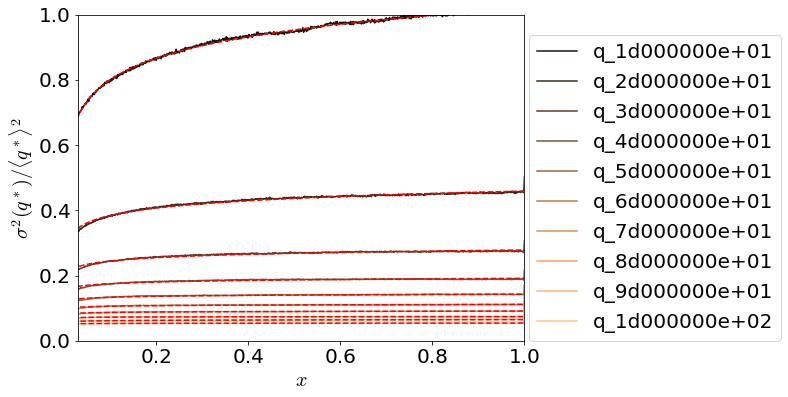

In [40]:
plt.figure(figsize=(8,6))
for run in runs:
    print("Working on %s" % run)
    # Open 
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    u_p = file['parameters']['u_p'][()]
    skipmax = file['parameters']['skipmax'][()]
    # Initialize
    set_q = ez.set_q(Nx,Ny,c_0,f,skipmax,u_p,q_in)
#     norm = set_q.dt**-1 * (4/3.) * np.pi * 1/float(Ny) * set_q.rho
    q8_in = q_in/set_q.norm

    # Close file:
    file.close()
    
    qmean = np.loadtxt(idir+'/'+run+'/mean_q.txt')
    qvar = np.loadtxt(idir+'/'+run+'/var_q.txt')
    x = np.loadtxt(idir+'/'+run+'/x.txt')
    plt.plot(x,qvar/qmean**2,label=run,c=cm.copper(q_in/100))
#     plt.axhline(y=q8_in,c='r',ls='--')
    m,b = np.polyfit(np.log(x[x>3e-2]),qvar[x>3e-2]/qmean[x>3e-2]**2,1)
    print(m)
    xplt = np.linspace(0,1,1000)
    plt.plot(xplt,b+m*np.log(xplt),'--r')

plt.xlabel(r"$x$")
plt.ylabel(r"$\sigma^2(q^*)/\langle q^* \rangle^2$",fontsize=20)
plt.legend(loc=(1.01,0.0))
plt.ylim(0,1)
plt.xlim(3e-2,1)
plt.show()

# Time series

## $q^*_{mid}$

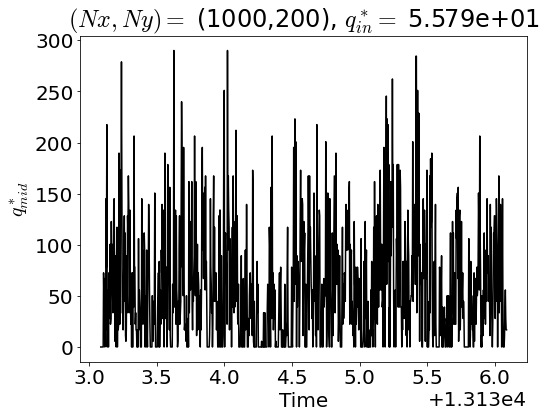

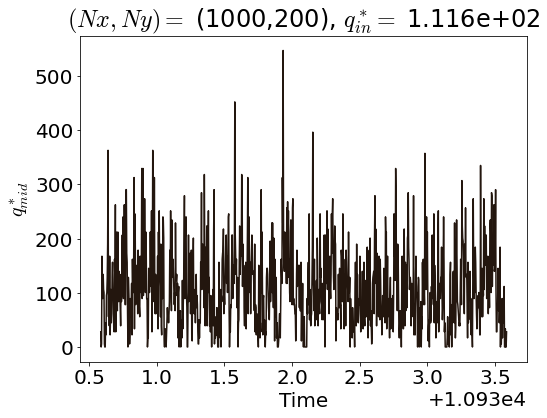

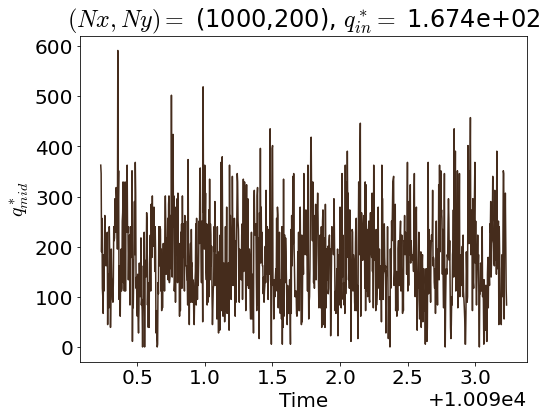

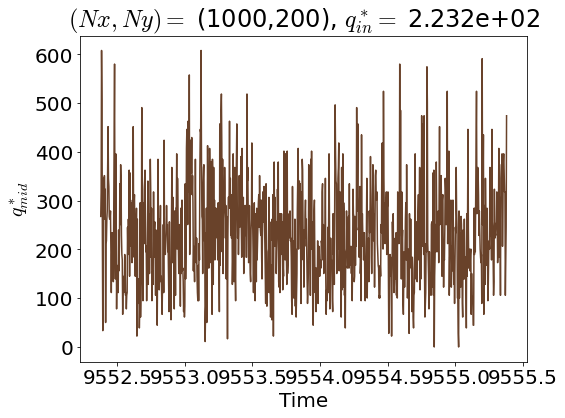

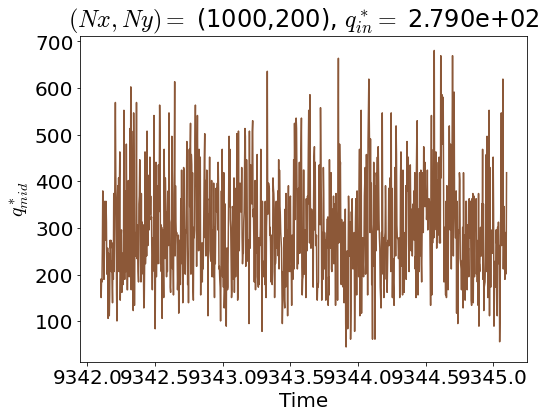

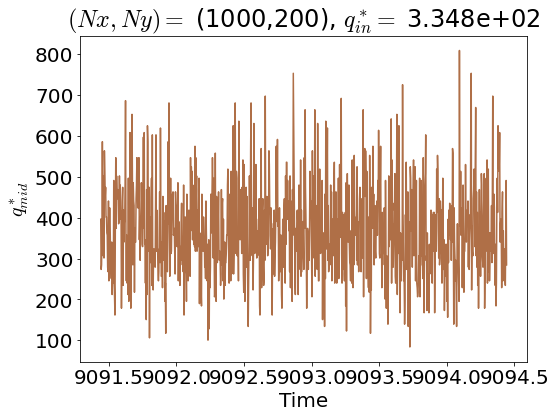

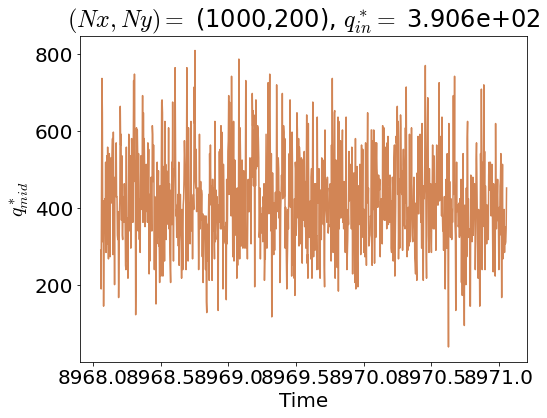

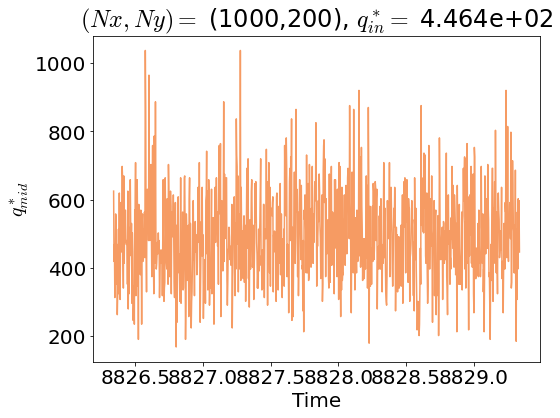

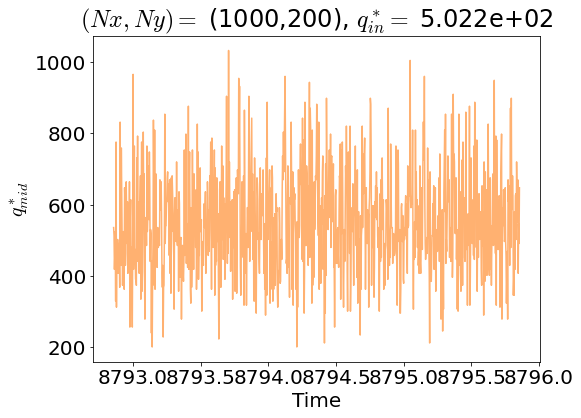

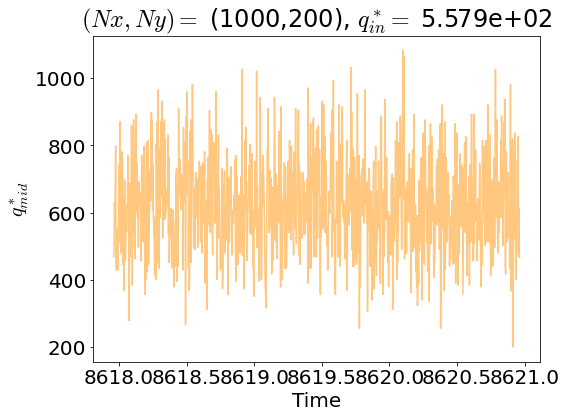

In [57]:
# idir = '../128x128'
idir = '../1000x200'
# run = 'q_1d000000e+01'
for run in runs:
    #         print("Working on run %s" % run)
    # Open 
    fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')

    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    u_p = file['parameters']['u_p'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

    # Normalize
    rho = 1.25
    dx = 1/(Nx-1)
    dt = skipmax*dx / u_p
    norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
    q8_in = q_in_real/norm

    # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
    time = file['scalars']['time'][()][300:]
    #         tstep = file['scalars']['tstep'][()]
    q_mid = file['scalars']['q_mid'][()][300:]
    #         q8_mid = q_mid*norm

    # Close file:
    file.close()

    plt.figure(figsize=(8,6))
    plt.plot(time[:1000],q_mid[:1000],color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)))
    plt.xlabel("Time")
    plt.ylabel("$q^*_{mid}$")
    plt.title(r'$(Nx,Ny) =$ (%s,%s), $q^*_{in} = $ %.3e' % (Nx,Ny,q8_in))
    plt.show()

## Time series PDFs

Working on ../1000x200


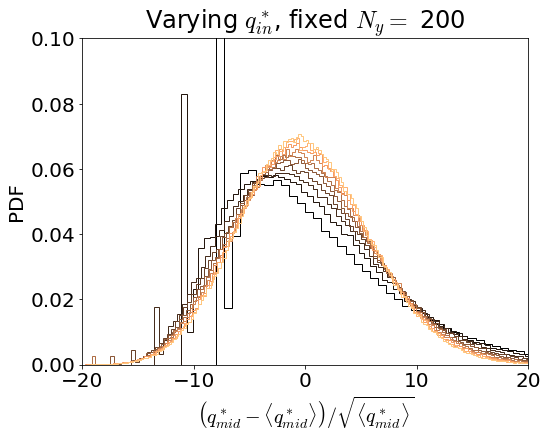

In [61]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(runs):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['q_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid
        q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=False,density=True,color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


    slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

plt.ylim(0,0.1)
plt.xlim(-20,20)
plt.xlabel(r"$\left(q^*_{mid}-\langle q^*_{mid}\rangle\right) / \sqrt{\langle q^*_{mid} \rangle }$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ %s" % Ny)
plt.show()
plt.close()  

Working on ../1000x200


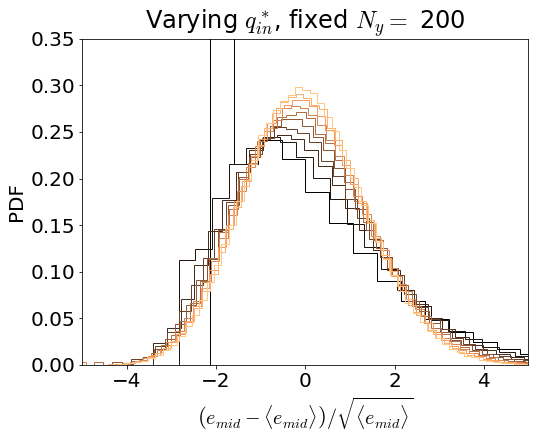

In [62]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(runs):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid
        q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=False,density=True,color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


    slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
    qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

plt.ylim(0,0.35)
plt.xlim(-5,5)
plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ %s" % Ny)
plt.show()
plt.close()  

In [63]:
import scipy.special as spec

In [91]:
def GammaDist(xplt,mean,var):
    theta = var/mean
    k = mean/theta #= mean**2/var
    return theta**(-k)*xplt**(k-1)*np.exp(-xplt/theta) / spec.gamma(k)

def NB(xplt,mean,var):
    p = (var-mean)/(var)
    r = mean**2/(var-mean)
    print(r,p)
    return spec.binom(r+xplt-1,xplt)*(p)**xplt*(1-p)**r

def GaussDist(xplt,mean,var):
    return (2*np.pi*var)**(-0.5)*np.exp(-(xplt-mean)**2/var/2)

Working on ../1000x200
46.015296343378026 0.4452379577839433


<Figure size 576x432 with 0 Axes>

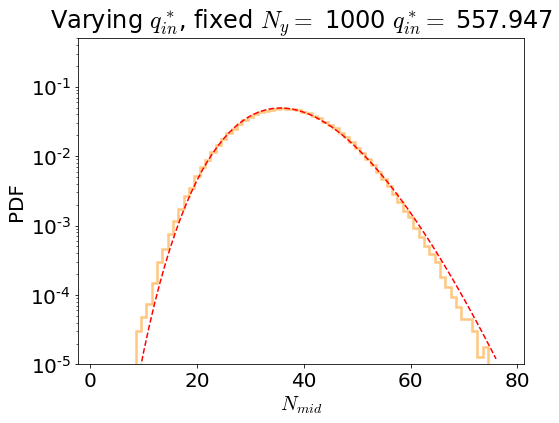

37.3627164613479 0.46730553810813247


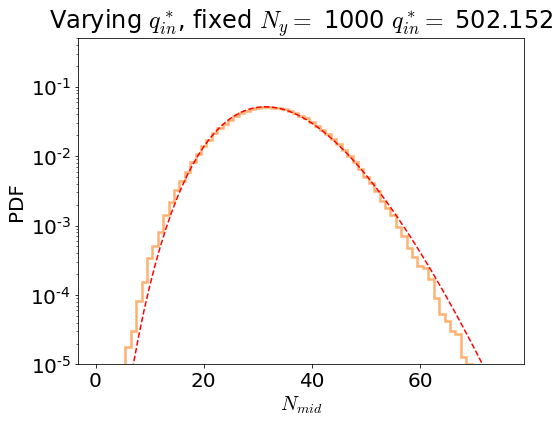

30.26499637276168 0.49024836296237045


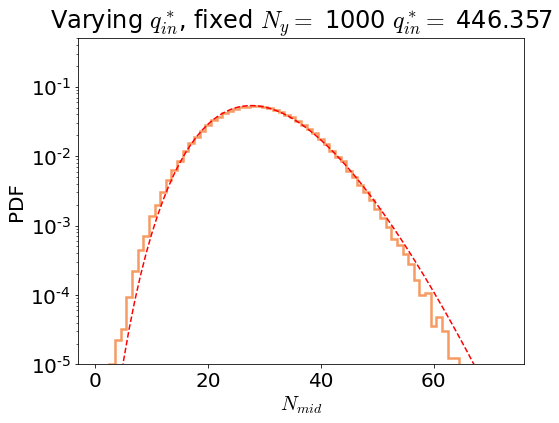

23.509310910381537 0.516994232606448


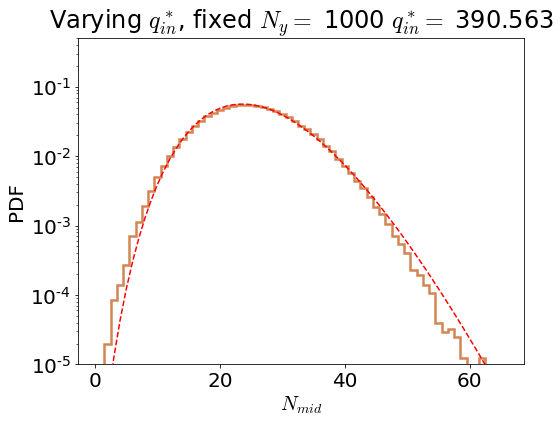

18.28795125771013 0.5401178925328262


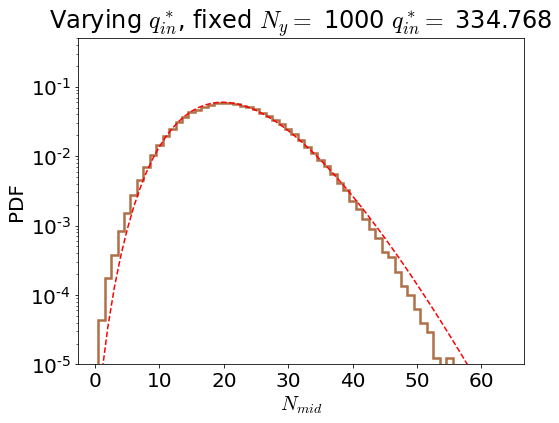

13.53215893017881 0.5681216763618955


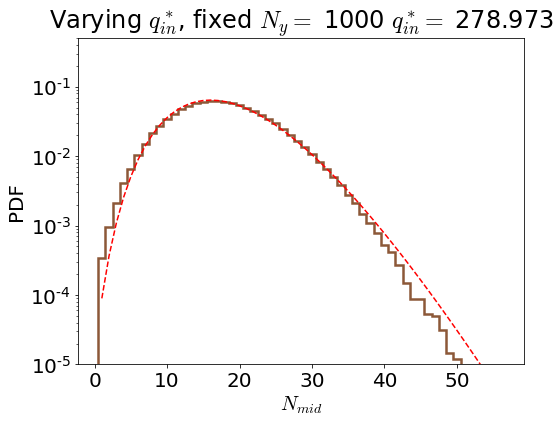

9.587224104926754 0.596722298634855


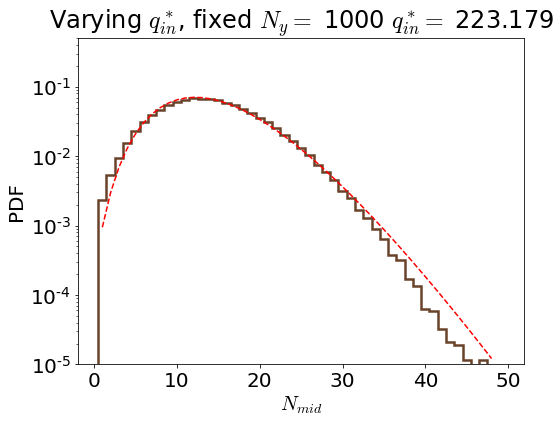

6.641017238538456 0.6159337767283377


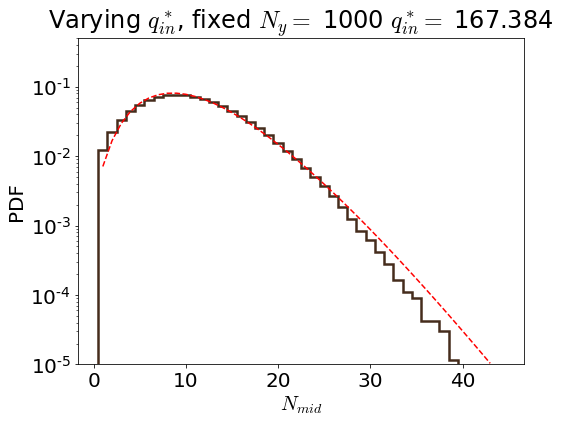

4.570304000571598 0.6161679059561715


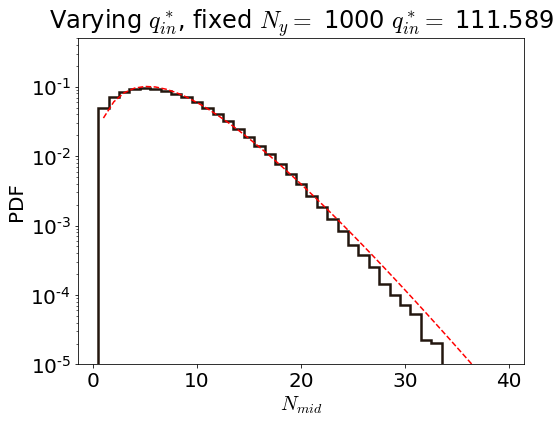

3.8488538373426877 0.5385031818199444


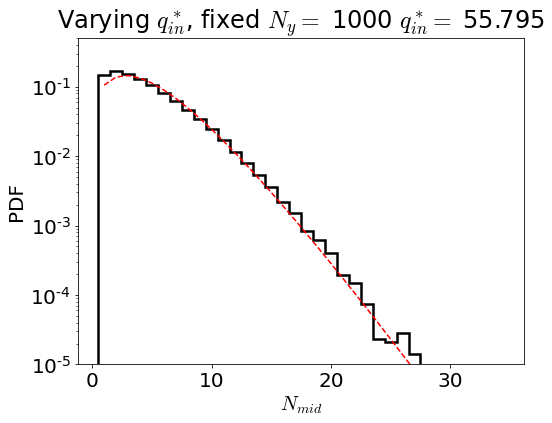

In [92]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
#         q_mid = file['scalars']['q_out'][()]
        q_mid = file['scalars']['e_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

        plt.figure(figsize=(8,6))

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        
        xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

        # ax=plt.gca()
        # ax.set_yscale('log')
        # plt.xlabel(r"$q_{out}$")
        plt.ylim(1e-5,0.5)
        plt.xlabel(r"$N_{mid}$")
        plt.ylabel("PDF")
        plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000"+r" $q^*_{in} =$ %.3f" % (q8_in))
#         plt.legend(loc=(1.01,0.0))
        plt.show()
        plt.close()  

Working on ../1000x200


<Figure size 576x432 with 0 Axes>

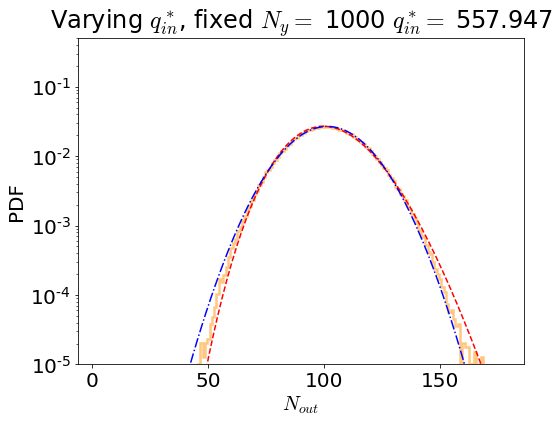

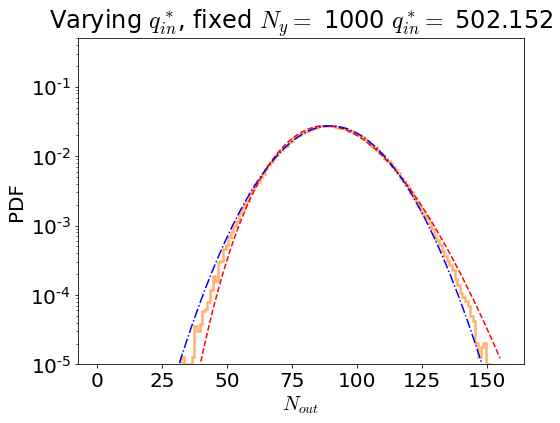

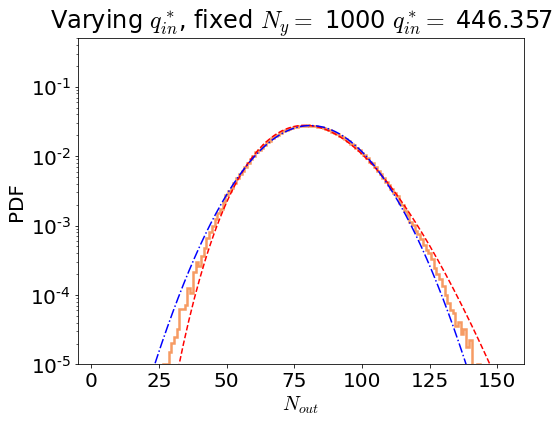

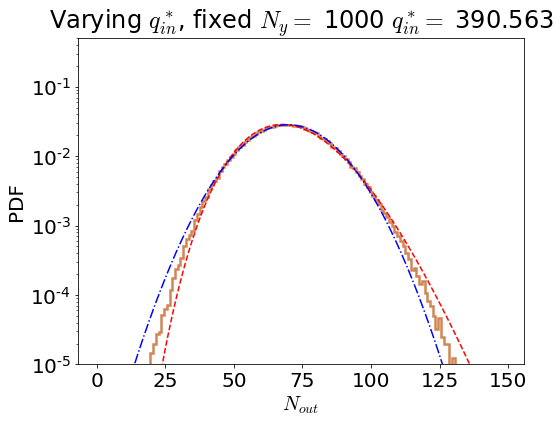

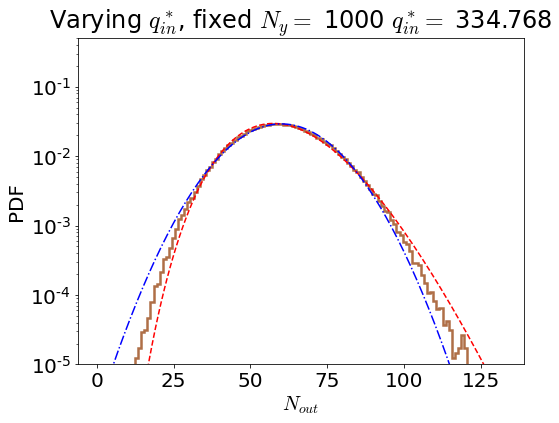

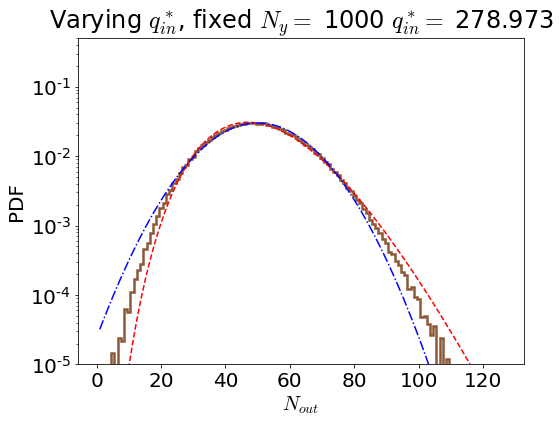

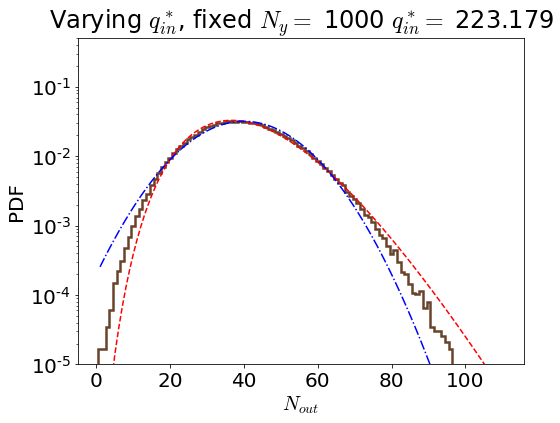

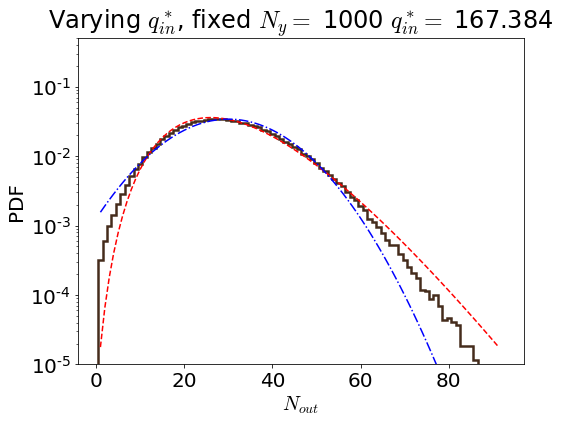

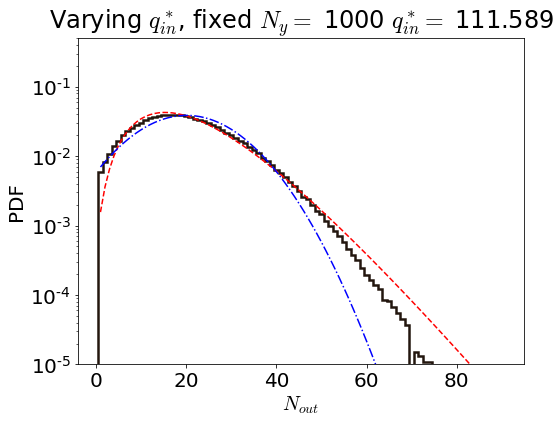

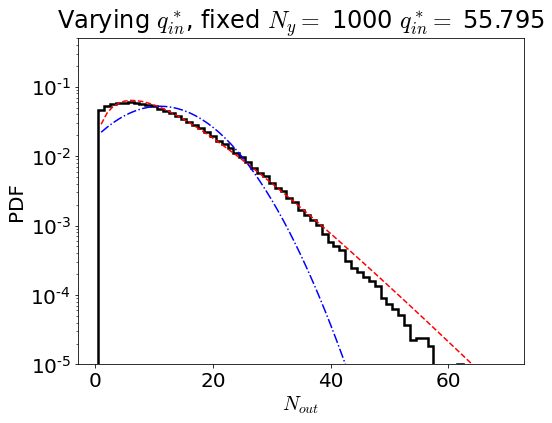

In [67]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['q_out'][()][300:]
#         q_mid = file['scalars']['e_mid'][()]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

        plt.figure(figsize=(8,6))

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        
        xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,GaussDist(xplt,np.mean(q),np.var(q)),'-.',color = 'b')
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

        # ax=plt.gca()
        # ax.set_yscale('log')
        # plt.xlabel(r"$q_{out}$")
        plt.ylim(1e-5,0.5)
        plt.xlabel(r"$N_{out}$")
        plt.ylabel("PDF")
        plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000"+r" $q^*_{in} =$ %.3f" % (q8_in))
#         plt.legend(loc=(1.01,0.0))
        plt.show()
        plt.close()  

Working on ../1000x200


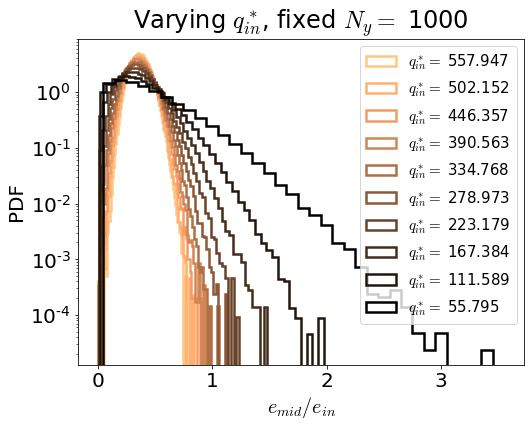

In [73]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]/q_in_real
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]

        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])

        if q_in_real/Ny==0.01:
#             xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#             plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',lw=2.5,color = 'r',label="Neg. Bin.") 
            xplt = np.linspace(np.min(q),np.max(q),1000)
            plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = 'r',lw=2.5,label="Gamma.") 

# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlabel(r"$q_{out}$")
# plt.ylim(1e-4,5)
plt.xlabel(r"$e_{mid}/e_{in}$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000")
plt.legend(loc=1,fontsize=15)#(1.01,0.0))
plt.savefig('./Figures/PDF_enormed_1000x200.png',bbox_inches='tight',dpi=100)
plt.show()  

Working on ../1000x200


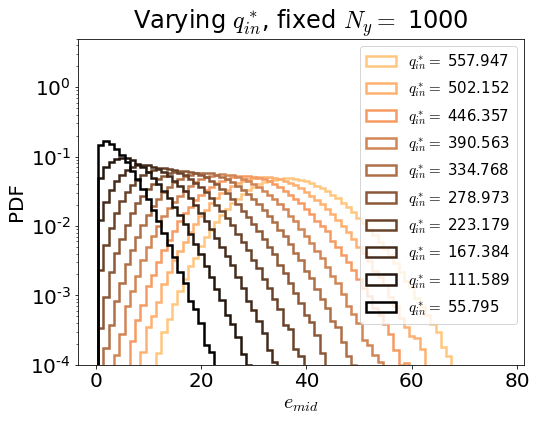

In [74]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['e_mid'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]

        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])

        if q_in_real/Ny==0.01:
            xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
            plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',lw=2.5,color = 'r',label="Neg. Bin.") 
#             xplt = np.linspace(np.min(q),np.max(q),1000)
#             plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = 'r',lw=2.5,label="Gamma.") 

# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlabel(r"$q_{out}$")
plt.ylim(1e-4,5)
plt.xlabel(r"$e_{mid}$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000")
plt.legend(loc=1,fontsize=15)#(1.01,0.0))
plt.savefig('./Figures/PDF_e_1000x200.png',bbox_inches='tight',dpi=100)
plt.show()  

Working on ../1000x200


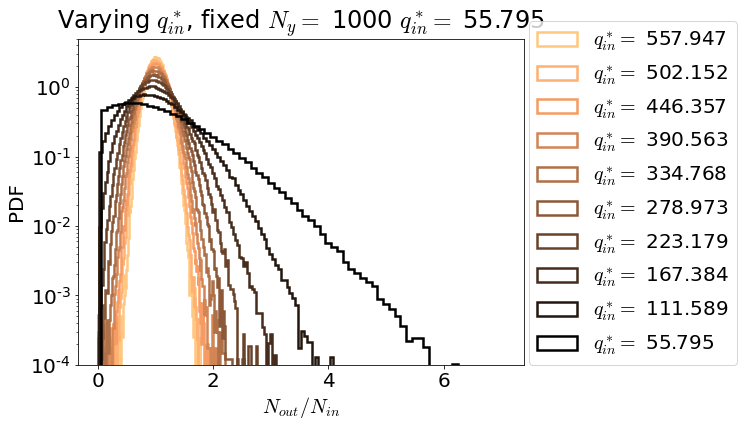

In [75]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['q_out'][()][300:]/q_in
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         plt.figure(figsize=(8,6))

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        
#         xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
# #         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
#         plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
#         plt.plot(xplt,GaussDist(xplt,np.mean(q),np.var(q)),'-.',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlabel(r"$q_{out}$")
plt.ylim(1e-4,5)
plt.xlabel(r"$N_{out}/N_{in}$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000"+r" $q^*_{in} =$ %.3f" % (q8_in))
plt.legend(loc=(1.01,0.0))
plt.show()
plt.close()  

Working on ../1000x200


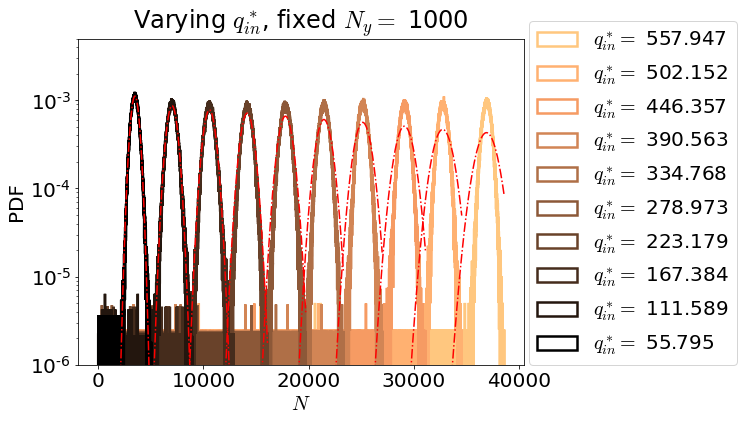

In [76]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['bed_activity'][()][300:]*Ny*Nx
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid[q_mid>0]
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

#         pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin,xmin = 3/norm,xmax = max(q), output='pdf')

#         # Finite size effect cutoff
#         nbeads = 3 # Number of grains considered 'too small' x avg skipmax
#         xcutoff = nbeads/norm # Five grains active total

#         xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)

#         plt.figure(figsize=(8,6))

#         if idir=='../256x256/':
#         plt.figure(figsize=(8,6))
#         plt.fill_between(xfill, 1e-7,1e0,facecolor=cm.Greys(0.1))
#         plt.loglog(x[pdf>0],pdf[pdf>0],marker='.',ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, %sx%s" % (q8_in,Nx,Ny),ms=10)
        d = np.diff(np.unique(q)).min()
        left_of_first_bin = q.min() - float(d)/2
        right_of_last_bin = q.max() + float(d)/2
        plt.hist(q, np.arange(left_of_first_bin, right_of_last_bin + d, d),histtype='step',log=True,density=True,lw=2.5,
                color=cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f" % (q8_in))#color = cm.copper((ii+1)/float(len(exps))),label=r"$\tau^* = $ %.3e" % tau_dict[exp])
        
        xplt = np.arange(np.min(q),np.max(q),dtype=np.int)
#         plt.plot(xplt,GammaDist(xplt,np.mean(q),np.var(q)),'--',color = cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
#         plt.plot(xplt,NB(xplt,np.mean(q),np.var(q)),'--',color = 'r')#cm.copper(cscale_qins_log2(q_in/Ny,q_ins_Ny)))
        plt.plot(xplt,GaussDist(xplt,np.mean(q),np.var(q)),'-.',color = 'r')
        
        
# #         # Fit
# #         if ((idir=='../400x80/') or (idir=='../128x128/')):
# #             fitmax = 1e-2  # For 200x40
# #         elif (idir=='../256x256/'):
# #             fitmax = 5e-3
# #         else:
# #             fitmax = 2e-3  # For 400x80
#         fitmin = xcutoff 
#         fitmax = 15/norm
#         xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
#         pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# # #         print(idir, run)
#         m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #         if idir=='../256x256/':
#         xpl = np.logspace(np.log10(fitmin),np.log10(fitmax),100)
#         plt.plot(xpl,10**b*xpl**(m),'--r',label =r"Fit, $n^{%.2f}$" % m,lw=2)
#         plt.legend()#loc=(1.01,0.0))
# #         plt.xlabel(r"Bed Activity")
#         slopes_l.append(m)
#         q8s_l.append(q8_in)
# #         else:
# #             plt.figure(figsize=(8,6))
# #             plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
# #             plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3e, 400x80" % (q8_in),ms=10)
# #             slopes_ba_400.append(m)
# #             q8_ins_ba_400.append(q8_in)


#     slopes_ba['%sx%s' % (Nx,Ny)] = np.array(slopes_l)
#     qin_reals_ba['%sx%s' % (Nx,Ny)] = np.array(q8s_l)

# plt.ylim(0,0.35)
# plt.xlim(-5,5)
# plt.xlabel(r"$\left(e_{mid}-\langle e_{mid}\rangle\right) / \sqrt{\langle e_{mid} \rangle }$")

# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlabel(r"$q_{out}$")
plt.ylim(1e-6,5e-3)
plt.xlabel(r"$N$")
plt.ylabel("PDF")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000")
plt.legend(loc=(1.01,0.0))
plt.show()
plt.close()  

# Power spectrum

In [77]:
import scipy.signal as sig

Working on ../1000x200


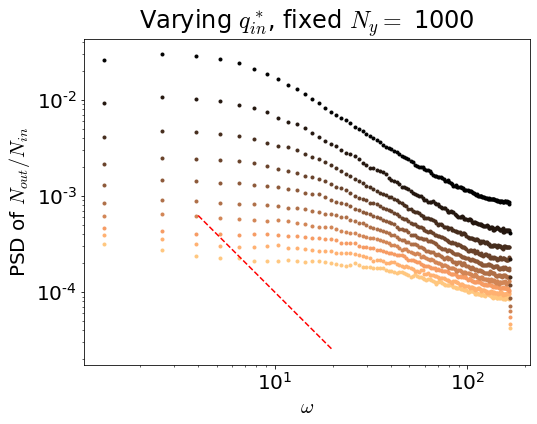

In [78]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['q_out'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid/q_in
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

        ## FFT
        freq, pds = sig.welch(q, 1/dt)#, nperseg=1024)
#         print(ps)

#         ps = np.abs(np.fft.fft(q))**2
#         freqs = np.fft.fftfreq(q.size, dt)
#         idx = np.argsort(freqs)
        
#         plt.figure(figsize=(8,6))

        plt.loglog(freq, pds,
                 color = cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f, %sx%s" % (q8_in,Nx,Ny),lw=2,ls='',marker='.')


# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlim(3e-1,1/dt/2)
# plt.ylim(2,7e1)

# fplot2 = np.logspace(np.log10(0.4),np.log10(4))
# plt.plot(fplot2,50*fplot2**(-0.2),'--g')
fplot = np.logspace(np.log10(4),np.log10(20))
plt.plot(fplot,1e-2*fplot**(-2),'--r')
# plt.plot(fplot,400*fplot**(-1.5),'--b')

plt.xlabel(r"$\omega$")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000")#+r" $q^*_{in} =$ %.3f" % (q8_in))
plt.ylabel(r"PSD of $N_{out}/N_{in}$")
#         plt.legend(loc=(1.01,0.0))
# plt.xlim(8,200)
plt.show()

Working on ../1000x200


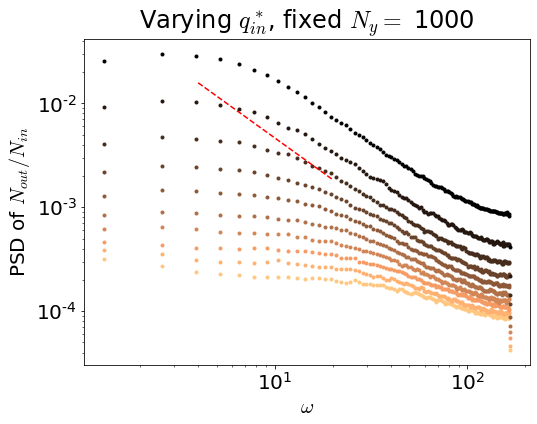

In [79]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['q_out'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid/q_in
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

        ## FFT
        freq, pds = sig.welch(q, 1/dt)#, nperseg=1024)
#         print(ps)

#         ps = np.abs(np.fft.fft(q))**2
#         freqs = np.fft.fftfreq(q.size, dt)
#         idx = np.argsort(freqs)
        
#         plt.figure(figsize=(8,6))

        plt.loglog(freq, pds,
                 color = cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f, %sx%s" % (q8_in,Nx,Ny),lw=2,ls='',marker='.')


# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlim(3e-1,1/dt/2)
# plt.ylim(2,7e1)

# fplot2 = np.logspace(np.log10(0.4),np.log10(4))
# plt.plot(fplot2,50*fplot2**(-0.2),'--g')
fplot = np.logspace(np.log10(4),np.log10(20))
plt.plot(fplot,1e-1*fplot**(-4/3.),'--r')
# plt.plot(fplot,400*fplot**(-1.5),'--b')

plt.xlabel(r"$\omega$")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000")#+r" $q^*_{in} =$ %.3f" % (q8_in))
plt.ylabel(r"PSD of $N_{out}/N_{in}$")
#         plt.legend(loc=(1.01,0.0))
# plt.xlim(8,200)
plt.show()

Working on ../1000x200


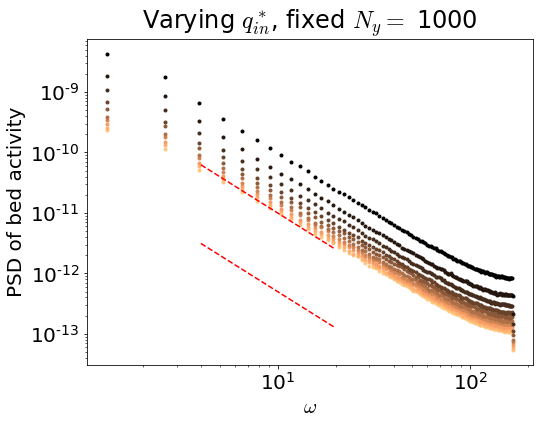

In [80]:
slopes_ba = dict([])
qin_reals_ba = dict([])
plt.figure(figsize=(8,6))
for idir in idirs:
    print("Working on %s" % idir)
    slopes_l = []
    q8s_l = []
    
    dirs = sorted(glob.glob(idir+'/q*'))

    runs = []
    for file in dirs:
        run = file.split('/')[2]
        q_in = float(run.split('_')[1].replace('d','.'))
        runs.append(run)

    # Sort run-names based on value of q_in
    runs = sorted(runs, key=lambda x: float(x.split('_')[1].replace('d','.')), reverse=False)
    
#     plt.figure(figsize=(8,6))
    for ii,run in enumerate(reversed(runs)):
#         print("Working on run %s" % run)
        # Open 
        fname = str(glob.glob(idir+'/'+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['tstep','time','bed_activity','q_mid','e_mid','e_last','q_out']
#         time = file['scalars']['time'][()]
#         tstep = file['scalars']['tstep'][()]
        q_mid = file['scalars']['bed_activity'][()][300:]
#         q8_mid = q_mid*norm

        # Close file:
        file.close()

    #     if (q_in_real<3):
        nbin = 20

        # Choose data to plot:
        q = q_mid/q_in
#         q = (q-np.mean(q))/np.sqrt(np.mean(q))

        ## FFT
        freq, pds = sig.welch(q, 1/dt)#, nperseg=1024)
#         print(ps)

#         ps = np.abs(np.fft.fft(q))**2
#         freqs = np.fft.fftfreq(q.size, dt)
#         idx = np.argsort(freqs)
        
#         plt.figure(figsize=(8,6))

        plt.loglog(freq, pds,
                 color = cm.copper(cscale_qins(q_in/Ny,q_ins_Ny)),label = r"$q^*_{in} =$ %.3f, %sx%s" % (q8_in,Nx,Ny),lw=2,ls='',marker='.')


# ax=plt.gca()
# ax.set_yscale('log')
# plt.xlim(3e-1,1/dt/2)
# plt.ylim(2,7e1)

# fplot2 = np.logspace(np.log10(0.4),np.log10(4))
# plt.plot(fplot2,50*fplot2**(-0.2),'--g')
fplot = np.logspace(np.log10(4),np.log10(20))
plt.plot(fplot,1e-9*fplot**(-2),'--r')
plt.plot(fplot,5*1e-11*fplot**(-2),'--r')
# plt.plot(fplot,400*fplot**(-1.5),'--b')

plt.xlabel(r"$\omega$")
plt.title("Varying $q^*_{in}$, fixed $N_y = $ 1000")#+r" $q^*_{in} =$ %.3f" % (q8_in))
plt.ylabel(r"PSD of bed activity")
#         plt.legend(loc=(1.01,0.0))
# plt.xlim(8,200)
plt.show()

## Waiting time PDF

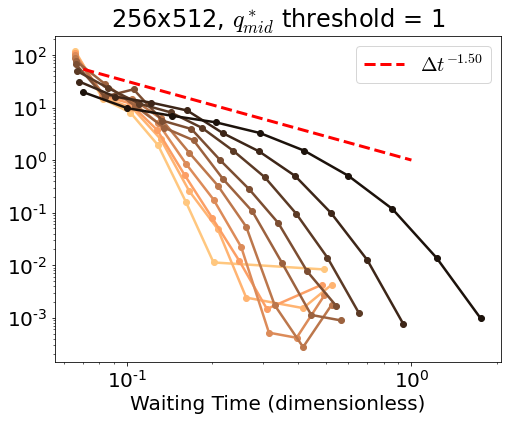

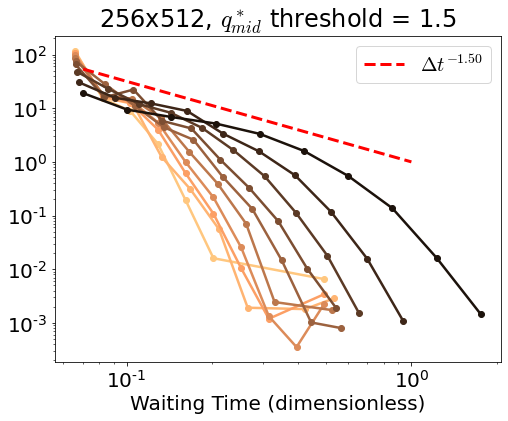

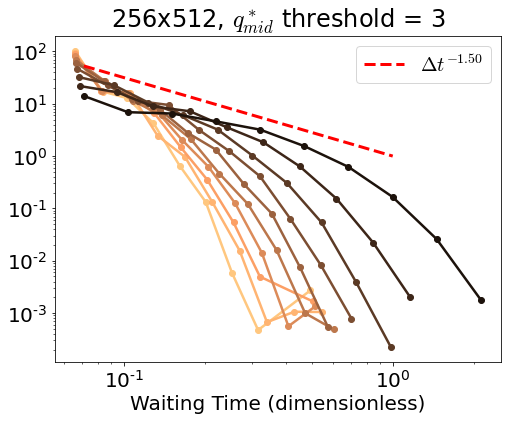

In [33]:
# Choose directory
# idir = '../200x40/'
Nx = 256
Ny = 512
idir = '../'+str(Nx)+'x'+str(Ny)+'/'
u_p = 1
skipmax=3
dx = 1/(Nx-1)

dt = skipmax*dx / u_p

exp_plot= [
    'q_1d000000e+00',
    'q_2d000000e+00',
    'q_3d000000e+00',
    'q_4d000000e+00',
    'q_5d000000e+00',
    'q_6d000000e+00',
    'q_7d000000e+00',
    'q_8d000000e+00',
    'q_9d000000e+00',
    'q_1d000000e+01',
]

for thresh in [
    1,
    1.5,
    3,
#     30,
#     40,
#     100,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    mindat = 5*dt
    # maxdat = 1.0

    nbins = 10

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        q = file['scalars']['q_mid'][()] # So that it's number of grains * vel
        
        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dat = onoff_dist(q,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(1),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, $q^*_{mid}$ threshold = %s" % (Nx,Ny,thresh))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

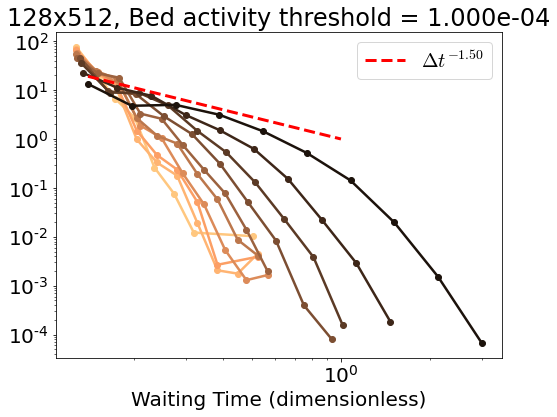

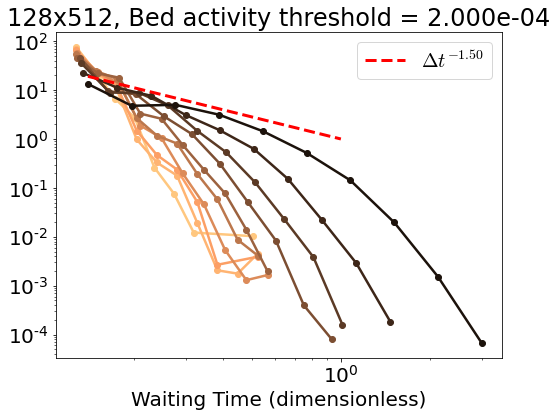

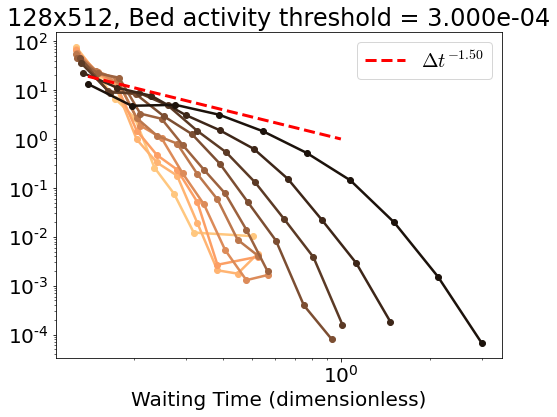

In [104]:
# Choose directory
# idir = '../200x40/'
Nx = 128
Ny = 512
idir = '../'+str(Nx)+'x'+str(Ny)+'/'
u_p = 1
skipmax=3
dx = 1/(Nx-1)

dt = skipmax*dx / u_p

exp_plot= [
    'q_1d000000e+00',
    'q_2d000000e+00',
    'q_3d000000e+00',
    'q_4d000000e+00',
    'q_5d000000e+00',
    'q_6d000000e+00',
    'q_7d000000e+00',
    'q_8d000000e+00',
    'q_9d000000e+00',
    'q_1d000000e+01',
]

for thresh in [
    1,
    2,
    3,
#     30,
#     40,
#     100,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    mindat = 5*dt
    # maxdat = 1.0

    nbins = 10
    
    thresh = thresh*10**(-4)

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        u_p = file['parameters']['u_p'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        rho = 1.25
        dx = 1/(Nx-1)
        dt = skipmax*dx / u_p
        norm = Ny*dt*(3/4.)*np.pi**(-1)*rho
        q8_in = q_in_real/norm

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        q = file['scalars']['q_mid'][()] # So that it's number of grains * vel
        
        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dat = onoff_dist(q,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(1),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, Bed activity threshold = %.3e" % (Nx,Ny,thresh))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

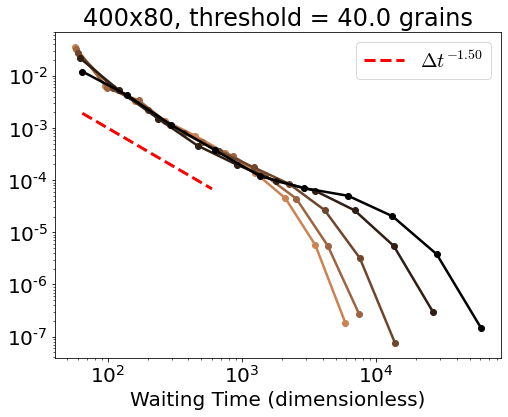

In [38]:
# Choose directory
idir = '../400x80/'
Nx = 400
Ny = 80

exp_plot= [
#     'q_1d000000e-02', # These don't exist yet
#     'q_1d513561e-02', # These don't exist yet
#     'q_2d290868e-02', # These don't exist yet
#     'q_3d467369e-02', # These don't exist yet
#     'q_5d248075e-02', # These don't exist yet
#     'q_7d943282e-02', # These don't exist yet
    'q_1d000000e-01', 
#     'q_1d359356e-01', 
    'q_1d847850e-01', 
#     'q_2d511886e-01', 
    'q_3d414549e-01', 
#     'q_4d641589e-01', 
    'q_6d309573e-01', 
#     'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
    'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
#     'q_1d000000e+01',
]

for thresh in [
#     10,
#     20,
    40,
#     80,
]:
    qm = []
    qs = []
    slopes_wt = []
    q8_ins_wt = []

    dt_min = 5e-3
    dt_max = 5
    pdf_min = 1e-3
    pdf_max = 5e2

    dt = 22.139999985694885 # Simulation parameter

    mindat = 2*dt
    # maxdat = 1.0

    nbins = 10

    thresh = thresh/(Nx*Ny)#20/(Nx*Ny)#10/(Nx*Ny)#9e-4 # Chosen by looking at PDFs, getting into the tail.

    plt.figure(figsize=(8,6))

    for ii,run in enumerate(reversed(exp_plot)):
        # Open 
        fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
        file = h5py.File(fname,'r')

        # Get parameters:
        Nx = file['parameters']['Nx'][()]
        Ny = file['parameters']['Ny'][()]
        c_0 = file['parameters']['c_0'][()]
        f = file['parameters']['f'][()]
        q_in = file['parameters']['q_in'][()]
        skipmax = file['parameters']['skipmax'][()]
        rho = 0.8
        dt = file['parameters']['dt'][()]
        if q_in<1:
            q_in_real = 1/int(1/q_in)
    #         print("q_in real",q_in_real)
        else:
            q_in_real = int(q_in)
    #         print("q_in > 1",int(q_in))

        # Normalize
        norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
        q8_in = norm*q_in_real

        # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
        time = file['scalars']['time'][()]
        tstep = file['scalars']['tstep'][()]
        q_out = file['scalars']['q_out'][()]
        q8_out = q_out*norm
        bed_activity = file['scalars']['bed_activity'][()]

        # Close file:
        file.close()

        ##############################

        # Choose data to plot:
        dt = np.diff(time)[0]
        dat = onoff_dist(bed_activity,dt,thresh)
        hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
        x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
        y = hist
    #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

        # Plot
    #     plt.figure(figsize=(8,6))
        plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
                   color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),lw=2.5)
    #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
    #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

    #     plt.axvline(x=int(1/q_in),color = 'b')

    #     # Finite size effect cutoff
    #     nbeads = 2# Number of grains considered 'too small'
    #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
    #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

    #     # Fit
    #     fitmax = 2e-3
    #     fitmin = xcutoff 
    #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
    #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
    #     slopes_ba.append(m)
    #     q8_ins_ba.append(q8_in)

    m = -3/2.
    b = 1.
    xpl = np.logspace(np.min(x),np.log10(600),100)
    plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)

    plt.legend()#loc=(1.01,0.0))
    plt.title("%sx%s, threshold = %s grains" % (Nx,Ny,thresh*Nx*Ny))
    plt.xlabel(r"Waiting Time (dimensionless)")
    # plt.xlabel(r"$q_{out}$")

    plt.show()
        
# slopes_ba = np.array(slopes_ba)
# q8_ins_ba = np.array(q8_ins_ba)

In [23]:
# # Choose directory
# idir = '../400x80/'
# Nx = 400
# Ny = 80

# exp_plot= [
# #     'q_1d000000e-02',  #
# #     'q_1d513561e-02',  #
# #     'q_2d290868e-02',  # These runs don't exist yet
# #     'q_3d467369e-02',  # 
# #     'q_5d248075e-02',  #
# #     'q_7d943282e-02',  #
#     'q_1d000000e-01', 
# #     'q_1d359356e-01', 
#     'q_1d847850e-01', 
# #     'q_2d511886e-01', 
#     'q_3d414549e-01', 
# #     'q_4d641589e-01', 
#     'q_6d309573e-01', 
# #     'q_8d576959e-01', 
# #     'q_1d165914e+00', 
# #     'q_1d584893e+00', 
#     'q_2d154435e+00', 
# #     'q_2d928645e+00', 
# #     'q_3d981072e+00', 
# #     'q_5d411695e+00', 
# #     'q_7d356423e+00', 
# #     'q_1d000000e+01',
# ]

# qm = []
# qs = []
# slopes_wt = []
# q8_ins_wt = []

# dt_min = 5e-3
# dt_max = 5
# pdf_min = 1e-3
# pdf_max = 5e2

# dt = 22.139999985694885 # Simulation parameter

# mindat = 2*dt
# # maxdat = 1.0

# nbin = 15

# thresh = 10/(Nx*Ny)#9e-4 # Chosen by looking at PDFs, getting into the tail.

# plt.figure(figsize=(8,6))

# for ii,run in enumerate(exp_plot):
#     # Open 
#     fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
#     file = h5py.File(fname,'r')
    
#     # Get parameters:
#     Nx = file['parameters']['Nx'][()]
#     Ny = file['parameters']['Ny'][()]
#     c_0 = file['parameters']['c_0'][()]
#     f = file['parameters']['f'][()]
#     q_in = file['parameters']['q_in'][()]
#     skipmax = file['parameters']['skipmax'][()]
#     rho = 0.8
#     dt = file['parameters']['dt'][()]
#     if q_in<1:
#         q_in_real = 1/int(1/q_in)
# #         print("q_in real",q_in_real)
#     else:
#         q_in_real = int(q_in)
# #         print("q_in > 1",int(q_in))
    
#     # Normalize
#     norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
#     q8_in = norm*q_in_real
    
#     # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
#     time = file['scalars']['time'][()]
#     tstep = file['scalars']['tstep'][()]
#     q_out = file['scalars']['q_out'][()]
#     q8_out = q_out*norm
#     bed_activity = file['scalars']['bed_activity'][()]
    
#     # Close file:
#     file.close()

#     ##############################

#     # Choose data to plot:
#     dt = np.diff(time)[0]
#     dat = onoff_dist(bed_activity,dt,thresh)
#     hist, bin_edges = np.histogram(np.log10(np.array(dat)),range=(np.log10(mindat),np.log10(np.max(dat))),density=True,bins=nbins)
#     x = np.array([(bin_edges[i+1]+bin_edges[i])/2. for i in range(len(hist))])  #center of bins
#     y = hist
# #     pdf,x = pdf_ccdf.pdf_ccdf(dat, n=nbins,xmin = mindat,xmax = max(dat),output='pdf')

#     # Plot
# #     plt.figure(figsize=(8,6))
#     plt.loglog(10**(x[(x>np.log10(mindat))&(y>0)]),10**(np.log10(y[(x>np.log10(mindat))&(y>0)])-x[(x>np.log10(mindat))&(y>0)]),ls='-',marker='o',label='',
#                color=cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),lw=2.5)
# #     plt.loglog(10**x,10**(np.log10(y)-x),ls='-',marker='o',label='',color=cm.copper(cscale_qins(q_in_real,qins)),lw=2.5)
# #     plt.loglog(x,pdf,marker='.',ls='',c = cm.copper(cscale_qins(q_in_real,qins)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

# #     # Finite size effect cutoff
# #     nbeads = 2# Number of grains considered 'too small'
# #     xcutoff = nbeads/(Nx*Ny) # Five grains active total
# #     xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
# #     plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))

# #     # Fit
# #     fitmax = 2e-3
# #     fitmin = xcutoff 
# #     xfit = x[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #     pdffit = pdf[(x<fitmax)&(x>fitmin)&(pdf>0)]
# #     m,b = np.polyfit(np.log10(xfit),np.log10(pdffit),1)
# #     slopes_ba.append(m)
# #     q8_ins_ba.append(q8_in)

# m = -3/2.
# b = 1.
# xpl = np.logspace(np.min(x),np.log10(600),100)
# plt.plot(xpl,b*xpl**(m),'--r',label =r"$\Delta t^{%.2f}$" % m,lw=3)


# plt.title("%sx%s, threshold = %s grains" % (Nx,Ny,thresh*Nx*Ny))
# plt.legend()#loc=(1.01,0.0))
# plt.xlabel(r"Waiting Time (dimensionless)")
# # plt.xlabel(r"$q_{out}$")

# plt.show()
        
# # slopes_ba = np.array(slopes_ba)
# # q8_ins_ba = np.array(q8_ins_ba)

## Random plots 

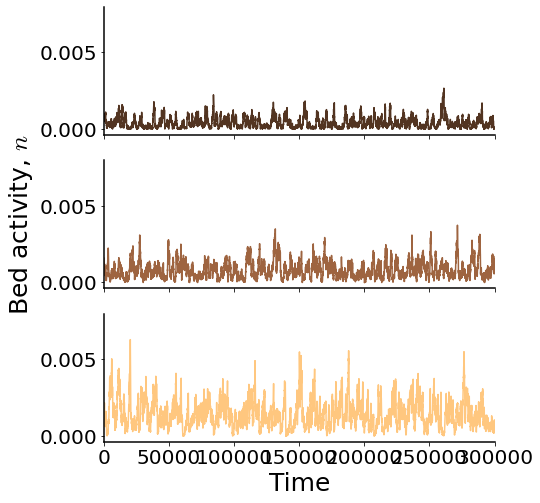

In [28]:
# Choose directory
idir = '../256x256/'
Nx = 256
Ny = 256

exp_plot = [
#     'q_1d000000e-01', ##
#     'q_1d359356e-01', 
#     'q_1d847850e-01', 
    'q_2d511886e-01', ##
#     'q_3d414549e-01', 
#     'q_4d641589e-01', 
#     'q_6d309573e-01', ##
    'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
#     'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
    'q_1d000000e+01',
]

nbin = 15
multf = 100
yint = 0.0

fig,ax = plt.subplots(3,1,figsize=(7,8),sharex='col',sharey='col')

for ii,run in enumerate(exp_plot):

    #####################
    #### TIME SERIES ####
    #####################
    for spine in ax[ii].spines.items():
        ax[ii].spines[spine[0]].set_linewidth(1.5)
    ax[ii].spines['right'].set_linewidth(0)
    ax[ii].spines['top'].set_linewidth(0)
    if ii==1:
#         ax[ii].set_ylabel(r"Sediment flux, $q^*$",fontsize=25)
        ax[ii].set_ylabel(r"Bed activity, $n$",fontsize=25)
    if ii==2:
        ax[ii].set_xlabel(r"Time",fontsize=25)
        #     plt.tight_layout()

        # Open 
    fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    
    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    rho = 0.8
    dt = file['parameters']['dt'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
#         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
#         print("q_in > 1",int(q_in))
    
    # Normalize
    norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
    q8_in = norm*q_in_real
    
    # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
    t = file['scalars']['time'][()]
    tstep = file['scalars']['tstep'][()]
    q_out = file['scalars']['q_out'][()]
    q8_out = q_out*norm
    q = file['scalars']['bed_activity'][()]
    
    # Close file:
    file.close()
    
    ### TIME SERIES
    ax[ii].plot(t-t[0],q,color=cm.copper(cscale_qins(q_in_real/Ny,[0.1/Ny,10/Ny])),label = r'$\langle q^*_{in} \rangle = $ %.3e' % q8_in)
#     tshift= t[0]
    deltat = 100000 #500000
    ax[ii].set_xlim(0,3*deltat)
#     ax[ii].set_ylim(0,0.02)
#     if ii==0:
#         ax[ii].legend(title="Input flux",loc=1)
#     else:
#         ax[ii].legend(loc=1)

###########################
# plt.savefig(odir+"Fig2_1_SIM.png",bbox_inches= "tight",dpi=300)

plt.show()

<ipython-input-26-1ff231595ef7>:103: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fff9bd30340> has a label of '_line3' which cannot be automatically added to the legend.
  first_legend = pdf_ax.legend(handles=tslope,frameon=False,loc=1,fontsize=25)


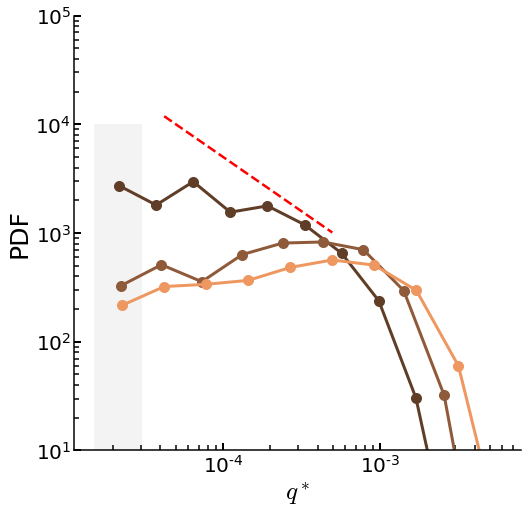

In [26]:
# Choose directory
idir = '../256x256/'
Nx = 256
Ny = 256

exp_plot = [
#     'q_1d000000e-01', ##
#     'q_1d359356e-01', 
#     'q_1d847850e-01', 
    'q_2d511886e-01', ##
#     'q_3d414549e-01', 
#     'q_4d641589e-01', 
#     'q_6d309573e-01', ##
    'q_8d576959e-01', 
#     'q_1d165914e+00', 
#     'q_1d584893e+00', 
#     'q_2d154435e+00', 
#     'q_2d928645e+00', 
#     'q_3d981072e+00', 
#     'q_5d411695e+00', 
#     'q_7d356423e+00', 
    'q_1d000000e+01',
]

nbin = 10
multf = 1
yint = 0.0


# Finite size effect cutoff
nbeads = 2# Number of grains considered 'too small'
xcutoff = nbeads/(Nx*Ny) # Five grains active total

# fig,(ax) = plt.subplots(1,1,figsize=(12,8))
fig, pdf_ax = plt.subplots(1,1,figsize=(8,8))
for ii,run in enumerate(exp_plot):
    # Open 
    fname = str(glob.glob(idir+run+'/*_scalars.h5')[0])
    file = h5py.File(fname,'r')
    
    # Get parameters:
    Nx = file['parameters']['Nx'][()]
    Ny = file['parameters']['Ny'][()]
    c_0 = file['parameters']['c_0'][()]
    f = file['parameters']['f'][()]
    q_in = file['parameters']['q_in'][()]
    skipmax = file['parameters']['skipmax'][()]
    rho = 0.8
    dt = file['parameters']['dt'][()]
    if q_in<1:
        q_in_real = 1/int(1/q_in)
#         print("q_in real",q_in_real)
    else:
        q_in_real = int(q_in)
#         print("q_in > 1",int(q_in))
    
    # Normalize
    norm = dt**-1 * (4/3.) * np.pi * 1/float(Ny) * rho
    q8_in = norm*q_in_real
    
    # Get time-series ['bed_activity', 'q_out', 'time', 'tstep']
    t = file['scalars']['time'][()]
    tstep = file['scalars']['tstep'][()]
    q_out = file['scalars']['q_out'][()]
    q8_out = q_out*norm
    q = file['scalars']['bed_activity'][()]
    
    # Close file:
    file.close()
    
    pdf, x = pdf_ccdf.pdf_ccdf(q[q>0], n=nbin, output='pdf')#,xmin = xcutoff,xmax = max(q), output='pdf')
    plt.loglog(x[pdf>0],pdf[pdf>0],marker='o',lw=3,ls='-',c = cm.copper(cscale_qins(q_in_real/Ny,q_ins_Ny)),label = r"$q_{in} =$ %.3e" % q_in_real,ms=10)

#     plt.axvline(x= xcutoff,color='b')

    xfill = np.linspace(xcutoff/nbeads,xcutoff,1000)
    plt.fill_between(xfill, 1e-2,1e4,facecolor=cm.Greys(0.1))
#     if run=='q_6d309573e-01':
#         # For plotting example gaussian
#         x = np.logspace(np.log10(2e-3),np.log10(max(q)),1000)
#         mean = np.nanmean(q)
#         std = np.nanstd(q)
#         gauss = pdf_ax.loglog(x,(1/(std*np.sqrt(2*np.pi)))*np.exp(-0.5*(x-mean)**2/std**2),ls = '--',c='grey',zorder=-10,lw=2.5,label="Gaussian")
    

# pdf_ax.set_ylim(1e-1,1e4)
pdf_ax.set_ylim(1e1,1e5)
# pdf_ax.set_xlim(2e-3,3)
pdf_ax.tick_params(axis='both',which = 'both',direction='in')#,width=2)
for spine in pdf_ax.spines.items():
    pdf_ax.spines[spine[0]].set_linewidth(1.5)
pdf_ax.spines['right'].set_linewidth(0)
pdf_ax.spines['top'].set_linewidth(0)
pdf_ax.tick_params(width=2,length=7,which='major')
pdf_ax.tick_params(width=1.5,length=5,which='minor')
pdf_ax.set_ylabel(r"PDF",fontsize=25)
pdf_ax.set_xlabel(r"$q^*$",fontsize=25)
# plt.text(2.5e-3,8e1, "g",fontsize=25)

yexp = -1.
tslope = pdf_ax.loglog(x[(xcutoff<x)&(x<9e-4)], 10**(-0.3)*x[(xcutoff<x)&(x<9e-4)]**(yexp),ls='--',color='r',lw=2.5)#,
#               label = 'Theoretical \n PDF exponent \n at threshold \n of motion',lw=2.5)
first_legend = pdf_ax.legend(handles=tslope,frameon=False,loc=1,fontsize=25)
pdf_ax.add_artist(first_legend)
# pdf_ax.legend(handles=gauss,frameon=False,loc=3,fontsize=25)

###########################
# plt.savefig(odir+"Fig2_2.png",bbox_inches= "tight",dpi=300)

plt.show()